In [86]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_specgram,
    show_confusion_matrix,
)


In [87]:
np.random.seed(0)

In [88]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [89]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [90]:
def add_noise_vector(vector, desired_snr_db=20):
    """
    Ajoute du bruit gaussien à un melspectrogramme ou un vecteur aplati tout en respectant un SNR donné.

    :param vector: Le vecteur brut (aplati).
    :param desired_snr_db: Rapport signal/bruit (en dB).
    :return: Le vecteur bruité.
    """
    signal_power = np.mean(vector ** 2)
    
    noise_power = signal_power / (10 ** (desired_snr_db / 10))
    noise_std_dev = np.sqrt(noise_power)
    
    noise = np.random.normal(0, noise_std_dev, vector.shape)
    
    # Ajout du bruit au 
    noisy_vector = vector + noise
    
    return noisy_vector  # Éviter les valeurs négatives
def time_shift_vector(vector, shift_pct=0.2):
    """
    Décale les colonnes d'un melspectrogramme aplati (vecteur brut).

    :param vector: Le vecteur brut (aplati).
    :param shift_pct: Pourcentage de décalage (positif ou négatif).
    :return: Le vecteur décalé.
    """
    # Dimensions du melspectrogramme (par défaut 20x20, à adapter si nécessaire)
    nmel, ncol = 20, 20  # Assurez-vous que ces dimensions correspondent à vos données
    matrix = vector.reshape((nmel, ncol))  # Reformater en matrice

    # Calcul du décalage en colonnes
    shift_amt = int(shift_pct * ncol)
    shifted_matrix = np.roll(matrix, shift_amt, axis=1)  # Décalage des colonnes

    return shifted_matrix.flatten()  # Reconvertir en vecteur aplati

def add_background_noise_vector(vector, desired_snr_db=20, nmel=20, ncol=20):
    """
    Ajoute un bruit de fond à un melspectrogramme ou un vecteur aplati tout en respectant un SNR donné.

    :param vector: Le vecteur brut (aplati) représentant un melspectrogramme.
    :param desired_snr_db: Rapport signal/bruit (en dB).
    :param nmel: Nombre de bandes Mel (hauteur du melspectrogramme).
    :param ncol: Nombre de colonnes du melspectrogramme (largeur).
    :return: Le vecteur avec bruit de fond.
    """
    bg_sig, sr = AudioUtil.open("src/classification/datasets/soundfiles/background.wav")
    if sr != 10200:
        bg_sig, sr = AudioUtil.resample((bg_sig, sr), newsr=10200)

    bg_melspec = AudioUtil.melspectrogram((bg_sig, sr), Nmel=nmel, Nft=512)

    if bg_melspec.shape[1] < ncol:
        raise ValueError("Le melspectrogramme de bruit de fond est trop petit pour être utilisé.")
    import random
    start_index = random.randint(0, bg_melspec.shape[1] - ncol)
    bg_melspec = bg_melspec[:, start_index:start_index + ncol]

    matrix = vector.reshape((nmel, ncol))

    signal_power = np.mean(matrix ** 2)
    noise_power = np.mean(bg_melspec ** 2)

    scaling_factor = np.sqrt(signal_power / (noise_power * 10 ** (desired_snr_db / 10)))

    scaled_bg_melspec = bg_melspec * scaling_factor

    noisy_melspec = matrix + scaled_bg_melspec

    return noisy_melspec.flatten()

In [91]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])
# print(myds["fire", 0])

18

In [92]:
from collections import Counter

# --- Paramètres ---

X = np.load(fm_dir + "feature_matrix_400.npy")
y = np.load(fm_dir + "labels_400.npy")

# Create a table of class occurrences in y
class_occurrences = Counter(y)
train_pct = 0.7

naudio_sum = 0
nclass = len(class_occurrences)
featveclen = X.shape[1]
nitems = len(y)
classnames = list(class_occurrences.keys())  # assure que classnames est bien défini

print("Class occurrences:")

for class_name, count in class_occurrences.items():
    
    naudio_sum += count
    print(f"{class_name}: {count}")
print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")



Class occurrences:
chainsaw: 160
fire: 153
fireworks: 120
gun: 40
Shape of the feature matrix : (473, 400)
Number of labels : 473


fire


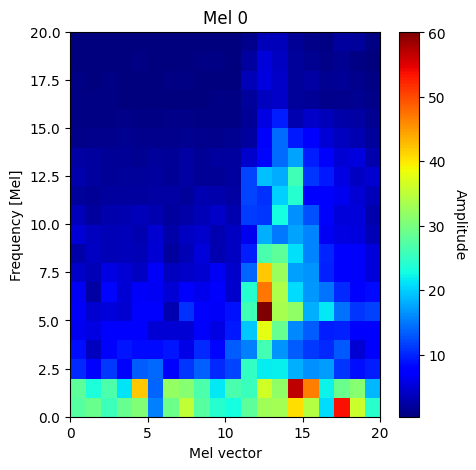

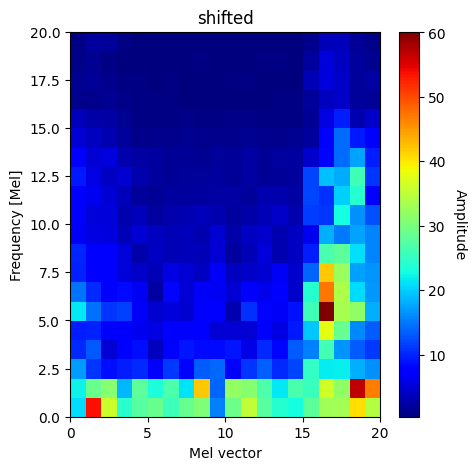

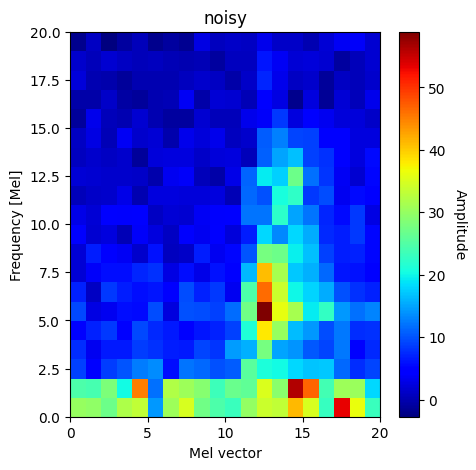

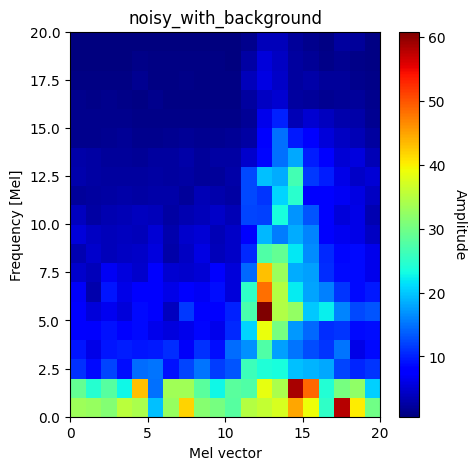

In [93]:
### Test des data augmentation --> Tests OK
# ----------------------------

vector = X[200]  
print(y[200])
fig, ax = plt.subplots(figsize=(5, 5))
plot_specgram(
    vector.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"Mel {0}",  
    xlabel="Mel vector",
    amplitude_label="Amplitude"
)


# ----------------------------

shifted = time_shift_vector(vector, shift_pct=0.2)
fig, ax = plt.subplots(figsize=(5, 5))

plot_specgram(
    shifted.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"shifted",  
    xlabel="Mel vector",
    amplitude_label="Amplitude"
)
noisy = add_noise_vector(vector, desired_snr_db=20)

fig, ax = plt.subplots(figsize=(5, 5))
plot_specgram(
    noisy.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"noisy",  
    xlabel="Mel vector",
    amplitude_label="Amplitude"
)




noisy_with_background = add_background_noise_vector(vector)
fig, ax = plt.subplots(figsize=(5, 5))
plot_specgram(
    noisy_with_background.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"noisy_with_background",  
    xlabel="Mel vector",
    amplitude_label="Amplitude"
)
plt.show()




In [41]:
# X_aug = []
# y_aug = []
# for i in range(len(X)):
#     vector = X[i]
#     label = y[i]

#     # Ajout de bruit
#     noisy_vector = add_noise_vector(vector, desired_snr_db=20)
#     # Ajout de bruit de fond
#     noisy_with_bg_vector = add_background_noise_vector(noisy_vector, desired_snr_db=20)
#     X_aug.append(noisy_with_bg_vector)
#     y_aug.append(label)



# # np.save(fm_dir + "feature_matrix_400_aug.npy", X_aug)
# # np.save(fm_dir + "labels_400_aug.npy", y_aug)

# X_aug = np.load(fm_dir + "feature_matrix_400_aug.npy")
# y_aug = np.load(fm_dir + "labels_400_aug.npy", allow_pickle=True)

# print(f"Shape of the feature matrix : {X_aug.shape}")
# print(f"Number of labels : {len(y_aug)}")


# X_aug -= np.mean(X_aug, axis=0)
# X_aug /= np.linalg.norm(X_aug, axis=0)


In [120]:
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

shift_pcts = [0.2,0.4,0.6]

n_augmentations_per_vector = 1 + len(shift_pcts) * 3  # Original + (shift + noise + background noise) par shift_pct
total_train_aug = len(X_train) * n_augmentations_per_vector
print(n_augmentations_per_vector)
# Préallouer les tableaux pour le training set
X_train_aug = np.zeros((total_train_aug, X_train.shape[1]))
y_train_aug = np.zeros(total_train_aug, dtype=y_train.dtype)

# Remplir les tableaux préalloués pour le training set
index = 0
for vector, label in tqdm(zip(X_train, y_train), total=len(X_train), desc="Augmentation du training set"):
    # Ajouter le vecteur original
    X_train_aug[index] = vector
    y_train_aug[index] = label
    # print(f"Index {index}: Original")

    index += 1
    

    # Appliquer les augmentations
    for shift_pct in shift_pcts:
        shifted_vector = time_shift_vector(vector, shift_pct=shift_pct)
        X_train_aug[index] = shifted_vector
        y_train_aug[index] = label
        # print(f"Index {index}: Shifted ({shift_pct*100}%)")
        index += 1

        noisy_vector = add_noise_vector(shifted_vector, desired_snr_db=20)
        X_train_aug[index] = noisy_vector
        y_train_aug[index] = label
        # print(f"Index {index}: Noisy")
        index += 1

        noisy_with_bg_vector = add_background_noise_vector(noisy_vector, desired_snr_db=20)
        X_train_aug[index] = noisy_with_bg_vector
        y_train_aug[index] = label
        # print(f"Index {index}: Noisy + Background")
        index += 1

10


Augmentation du training set:   0%|          | 0/331 [00:00<?, ?it/s]

Augmentation du test set:  13%|█▎        | 18/142 [00:36<04:12,  2.04s/it]


KeyboardInterrupt: 

Augmentation du training set:   0%|          | 0/331 [00:00<?, ?it/s]

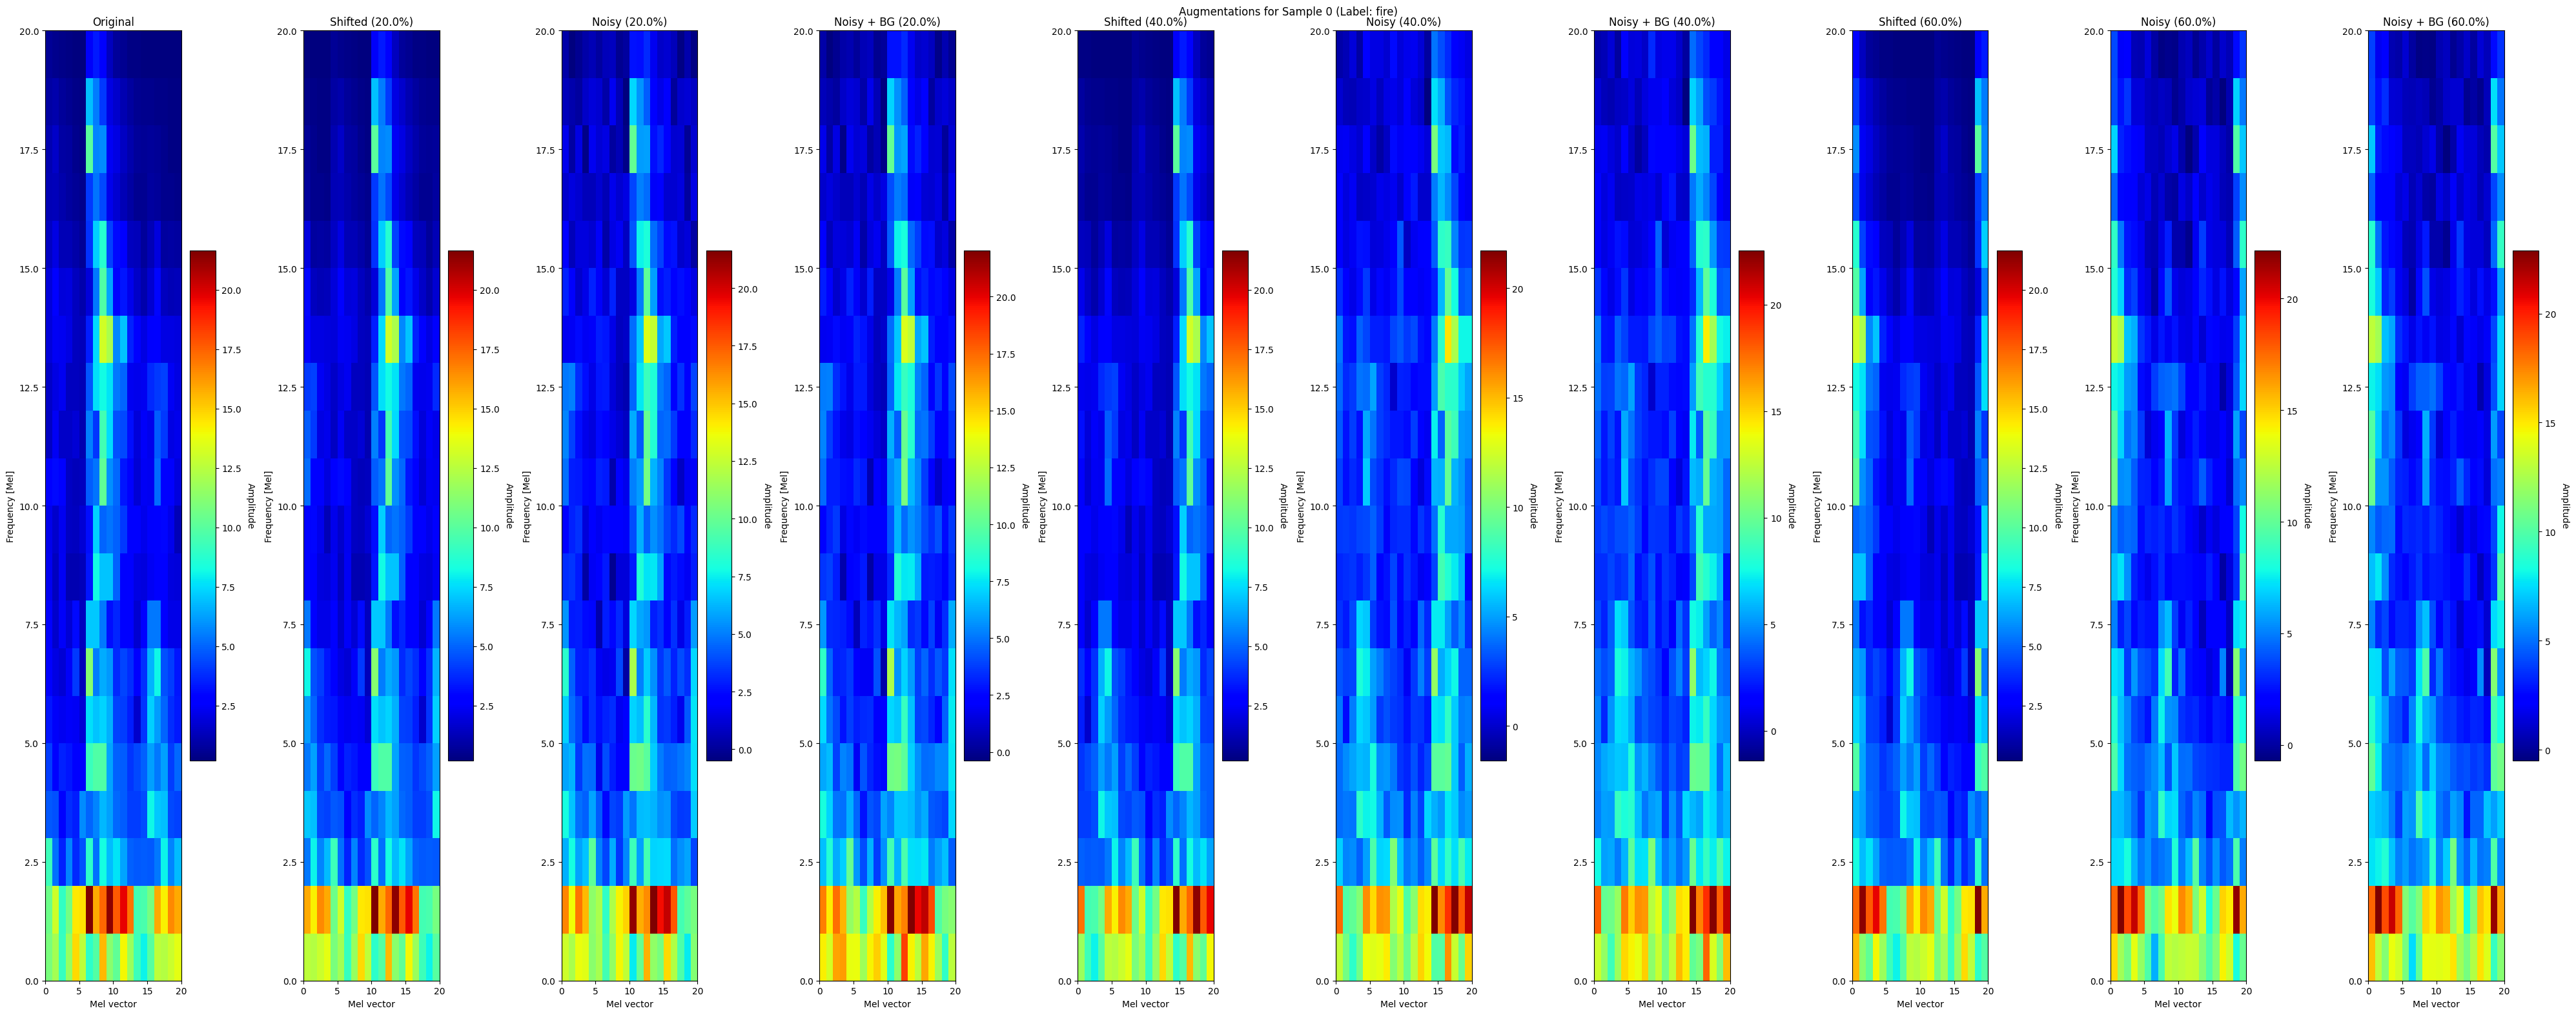

Augmentation du training set:   0%|          | 1/331 [00:10<55:54, 10.17s/it]

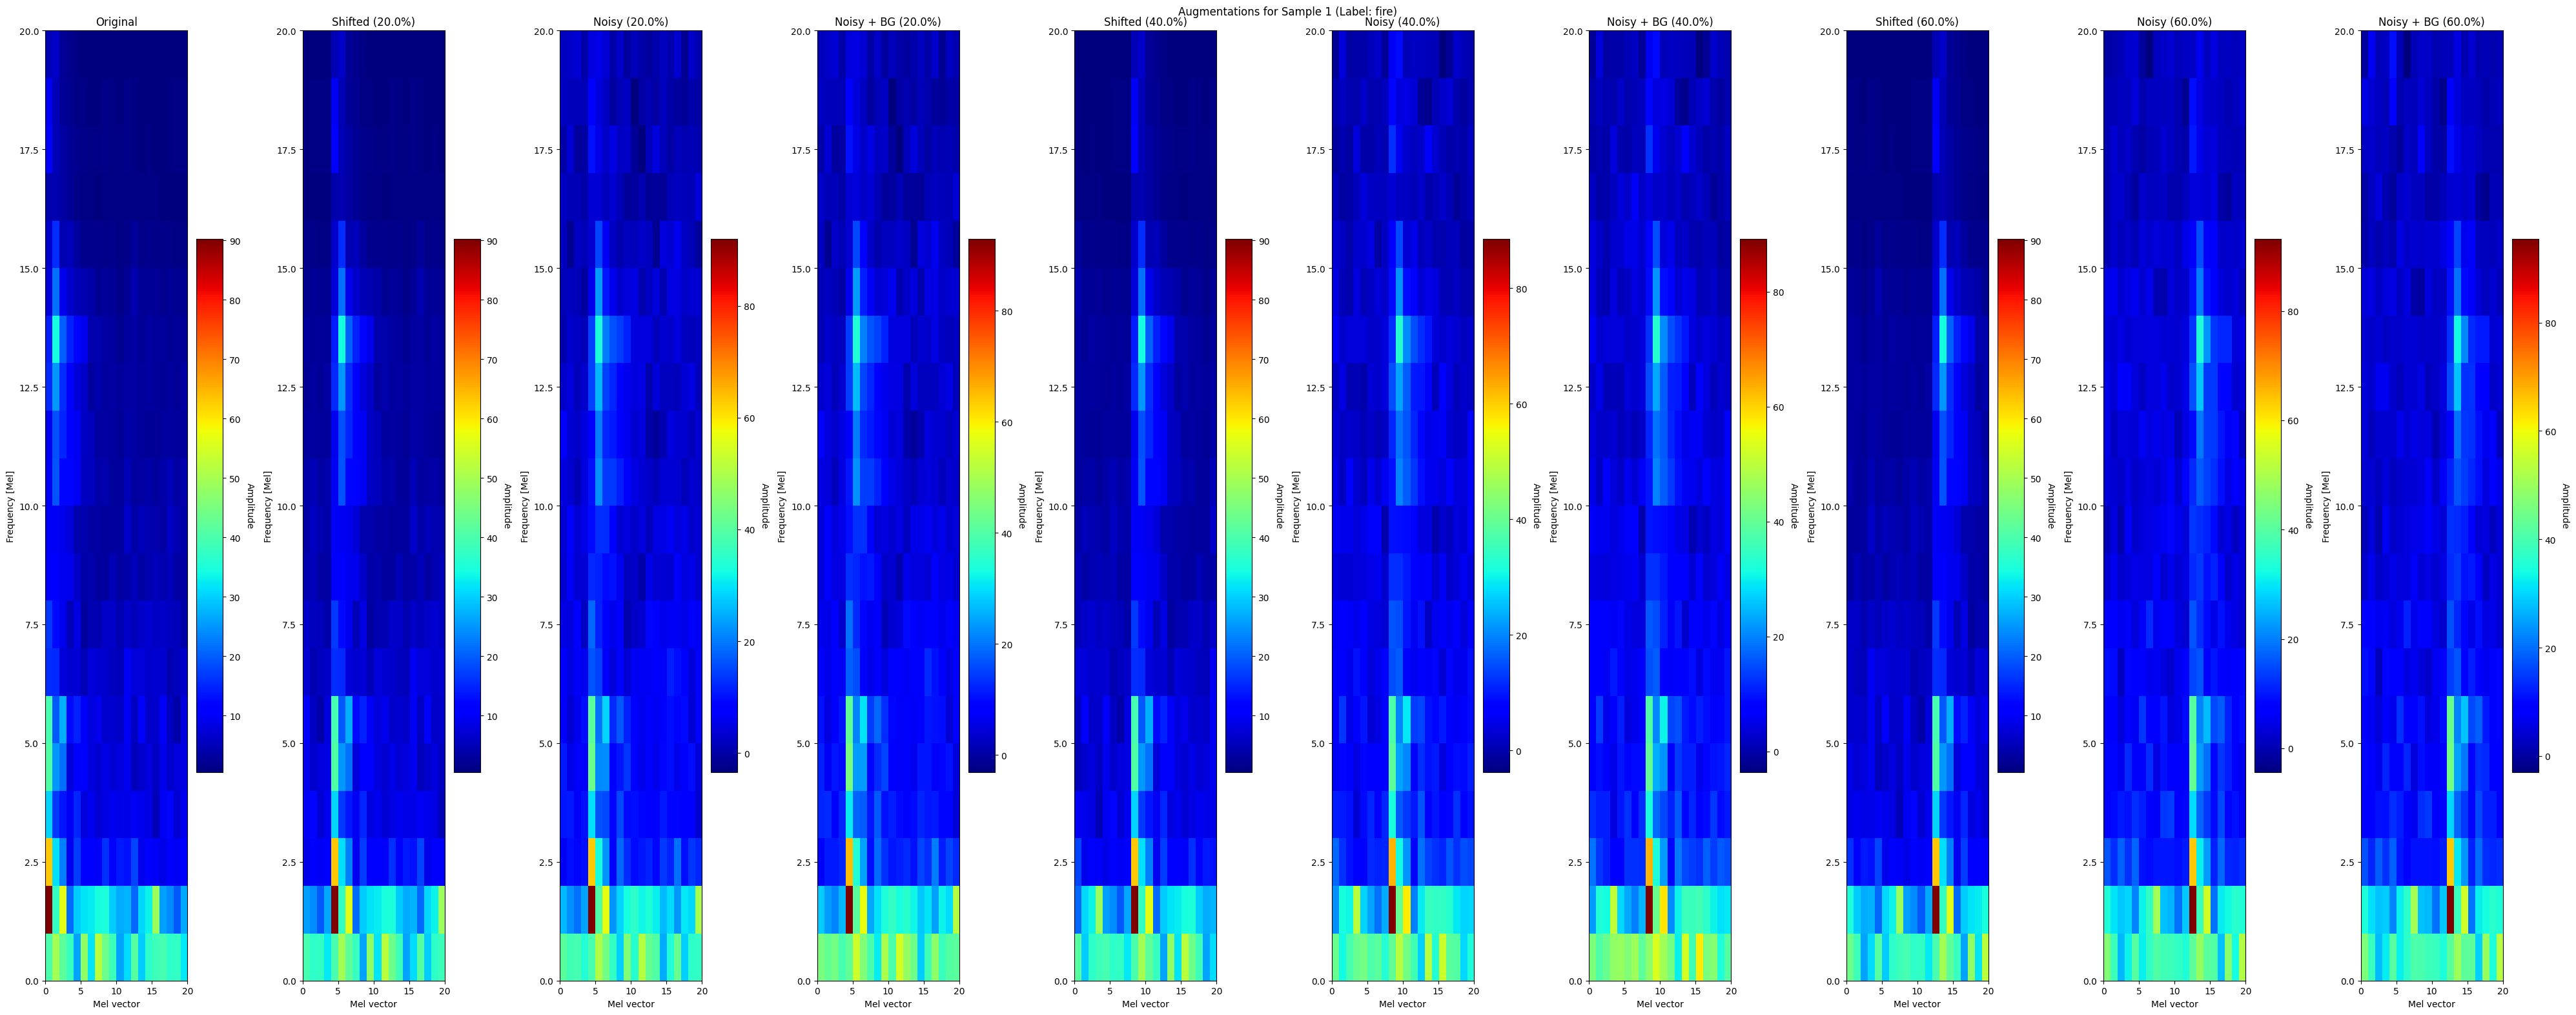

Augmentation du training set:   1%|          | 2/331 [00:19<54:35,  9.96s/it]

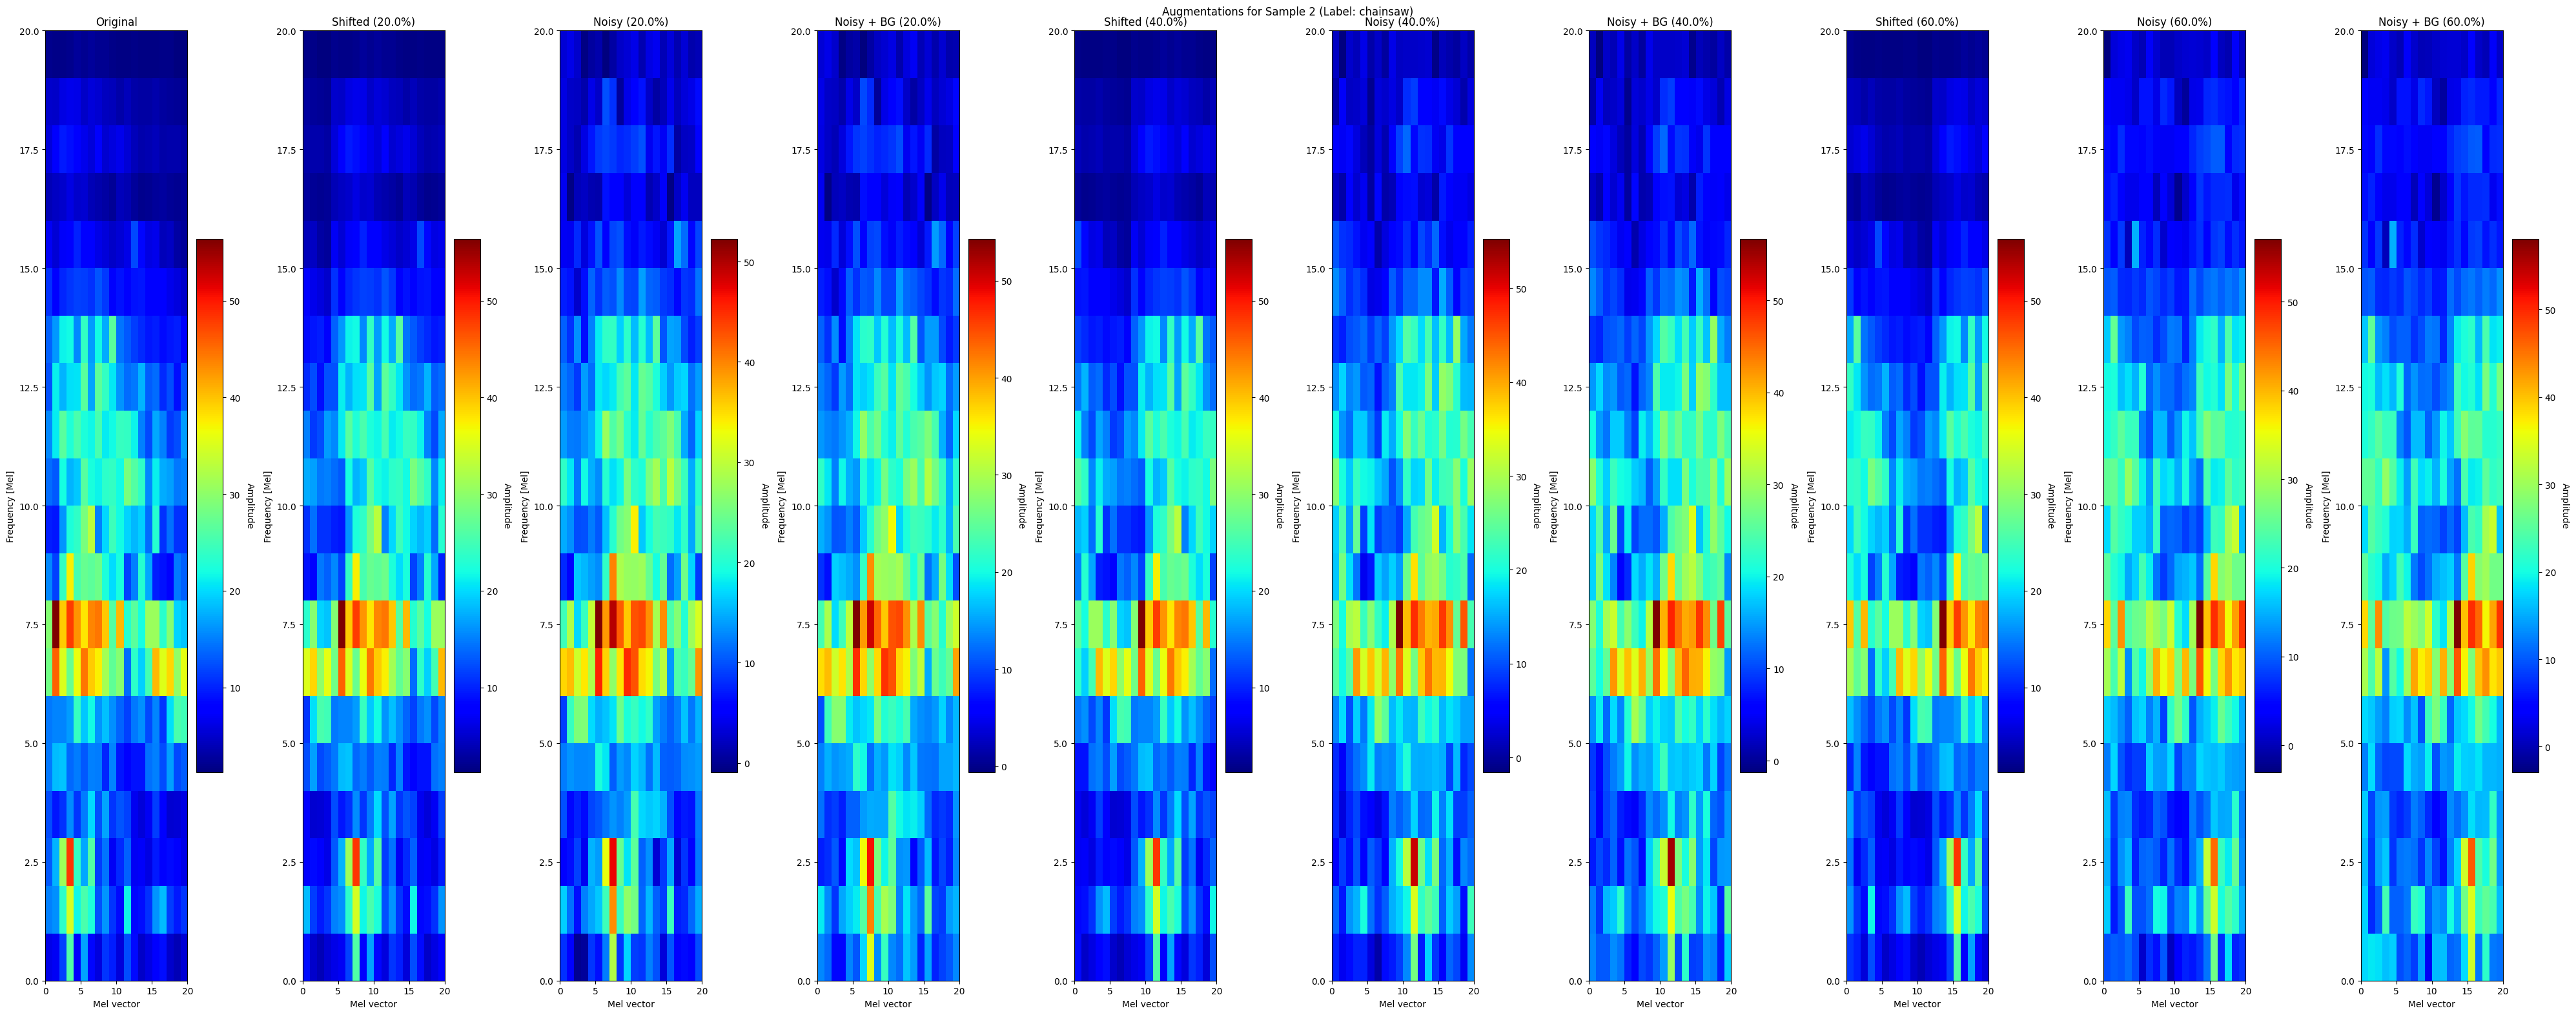

Augmentation du training set:   1%|          | 3/331 [00:29<52:32,  9.61s/it]

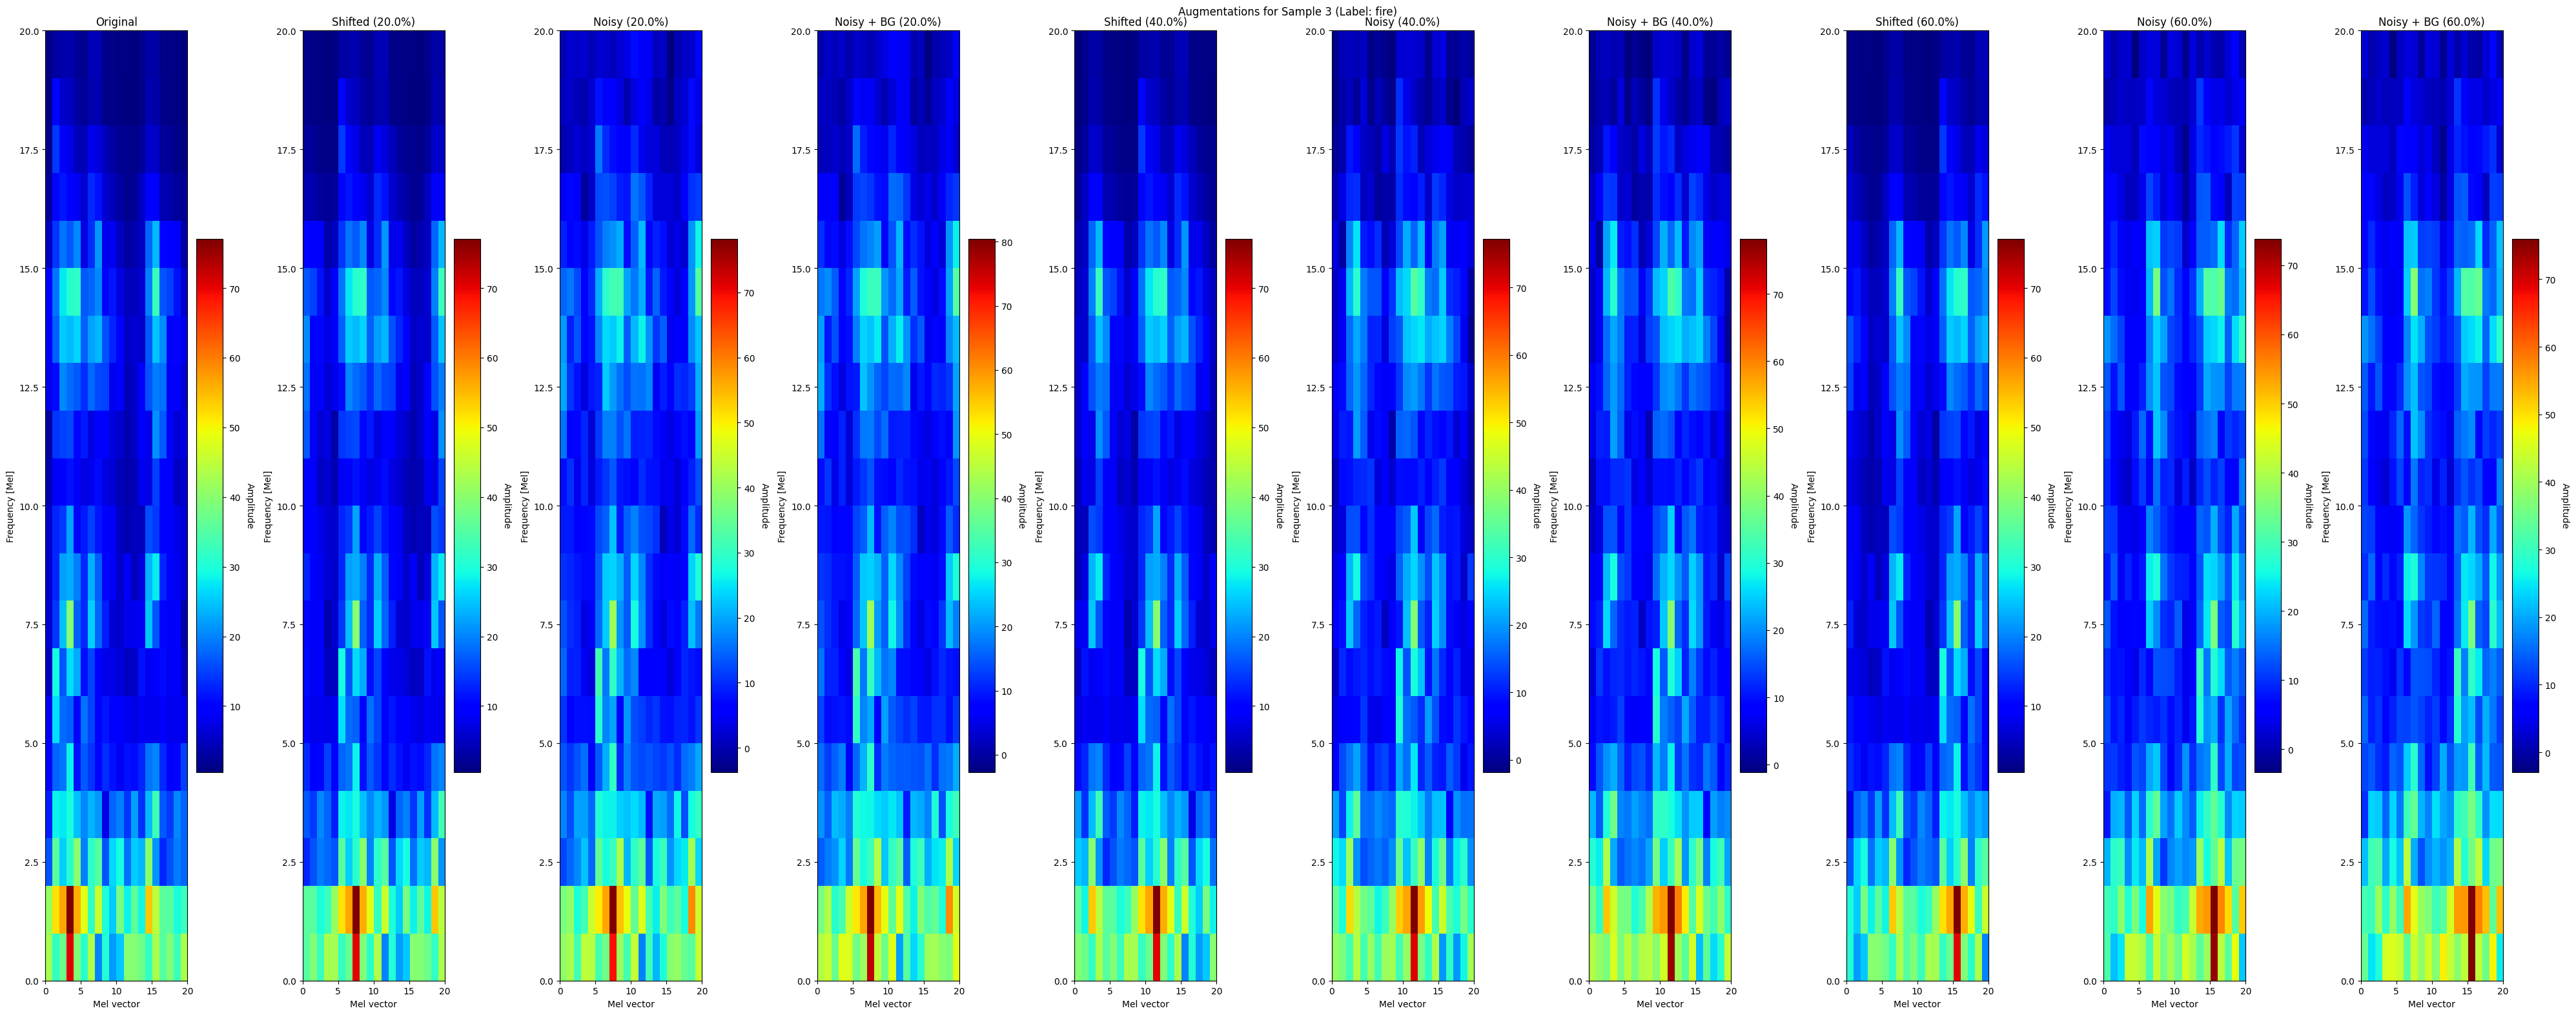

Augmentation du training set:   1%|          | 4/331 [00:38<52:49,  9.69s/it]

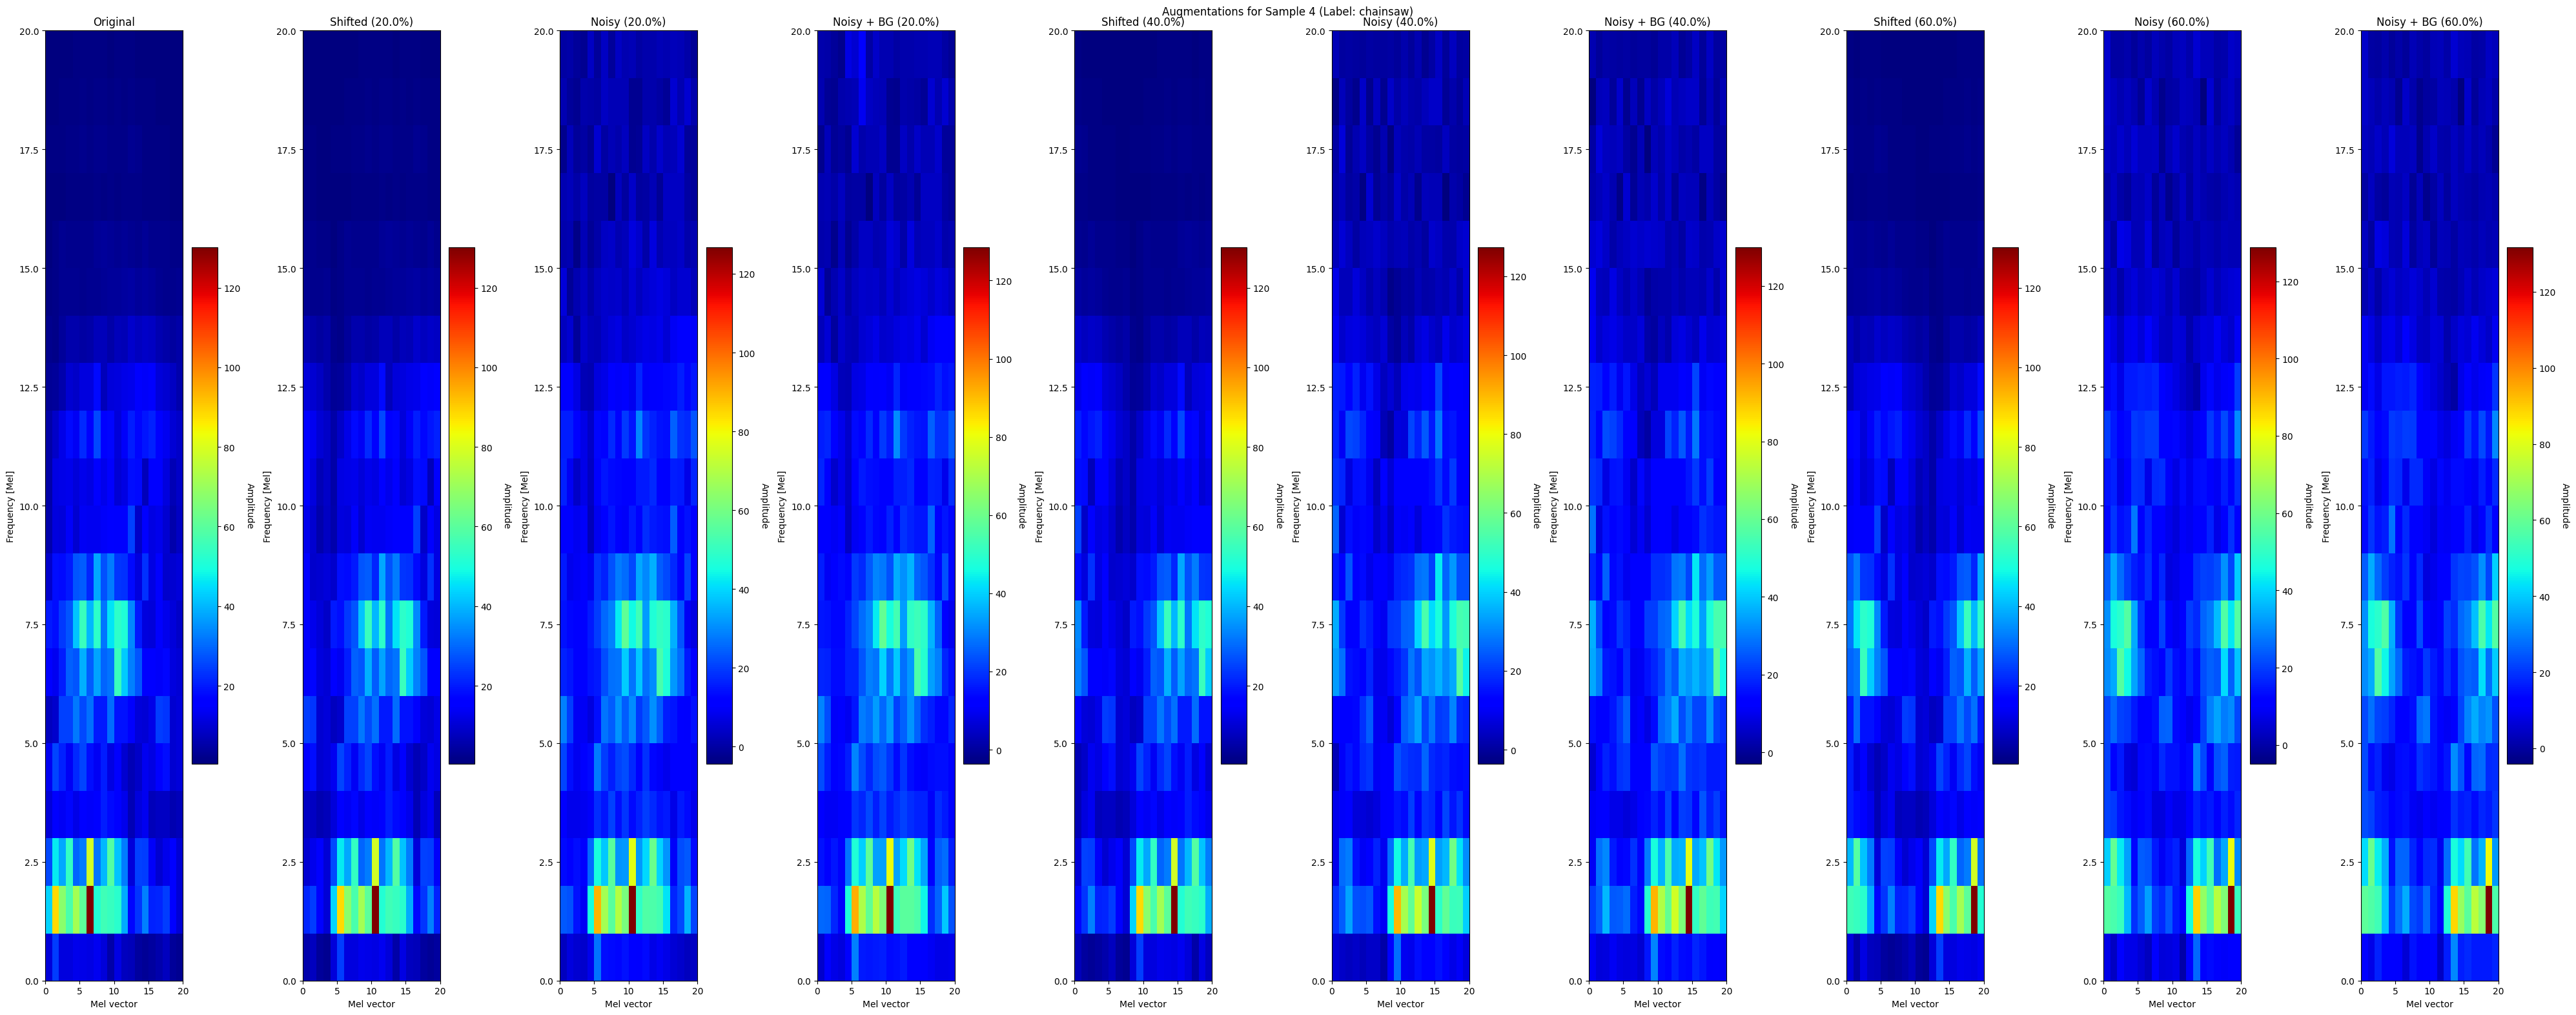

Augmentation du training set:   2%|▏         | 5/331 [00:50<55:13, 10.17s/it]


KeyboardInterrupt: 

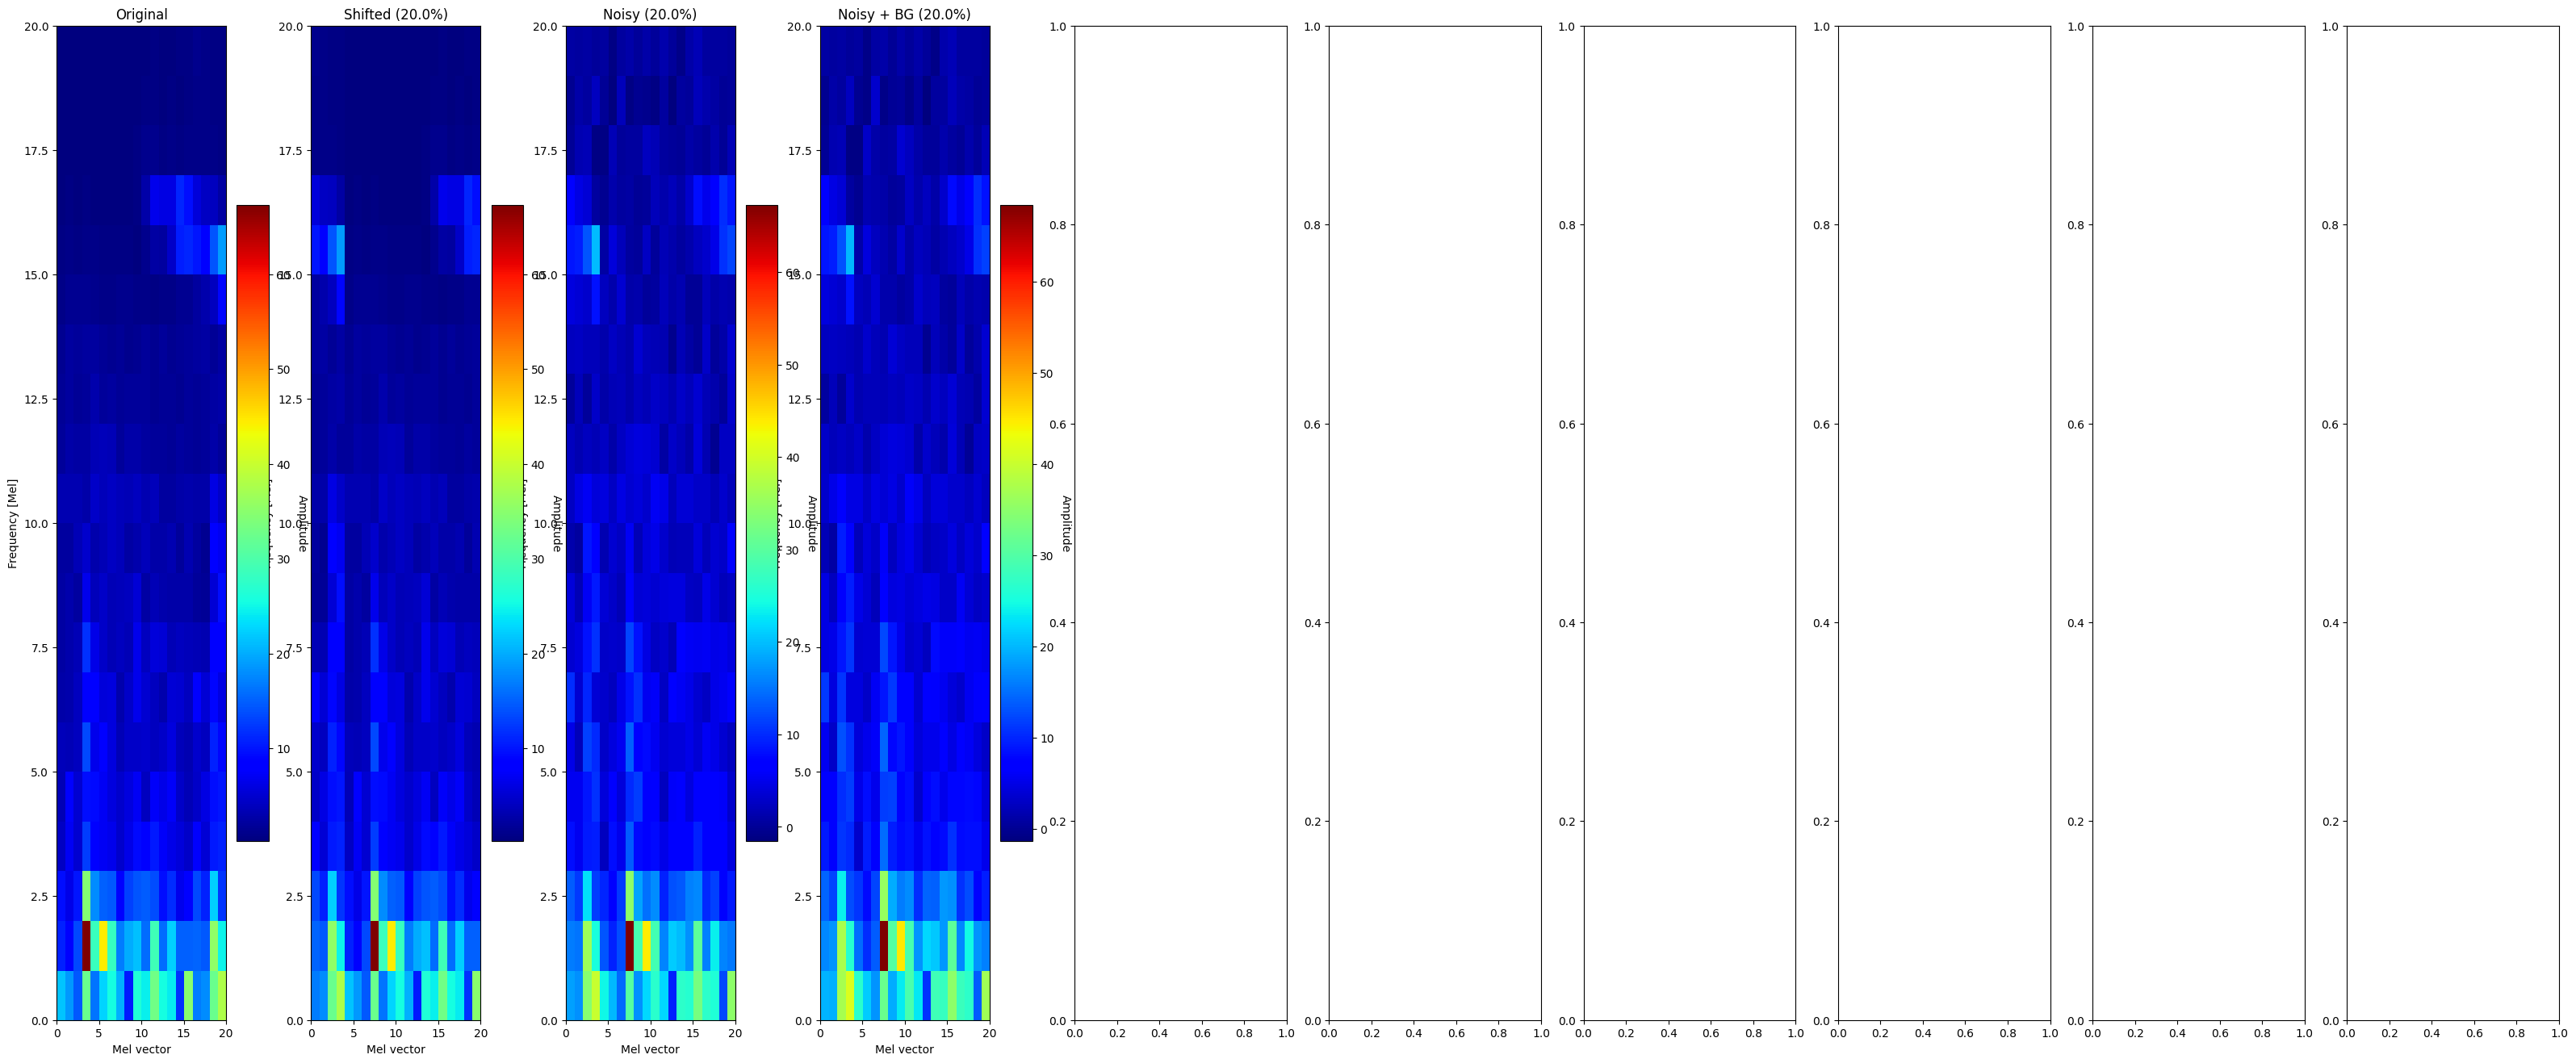

In [121]:
from tqdm import tqdm
import matplotlib.pyplot as plt

index = 0
for i, (vector, label) in enumerate(tqdm(zip(X_train[-10:], y_train[-10:]), total=len(X_train), desc="Augmentation du training set")):
    fig, axes = plt.subplots(1, 10, figsize=(40, 16))  # Créez une figure avec 7 sous-graphiques

    # Ajouter le vecteur original
    vector = X_train_aug[index]
    label = y_train_aug[index]
    plot_specgram(
        vector.reshape((20, 20)), 
        ax=axes[0],
        is_mel=True,
        title="Original",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    # Appliquer les augmentations pour chaque shift_pct
    for j, shift_pct in enumerate(shift_pcts):
        # Décalage temporel
        shifted_vector = X_train_aug[index]
        label = y_train_aug[index]
        plot_specgram(
            shifted_vector.reshape((20, 20)), 
            ax=axes[1 + j * 3],
            is_mel=True,
            title=f"Shifted ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )
        index += 1

        # Bruit gaussien
        noisy_vector = X_train_aug[index]
        label = y_train_aug[index]
        plot_specgram(
            noisy_vector.reshape((20, 20)), 
            ax=axes[2 + j * 3],
            is_mel=True,
            title=f"Noisy ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )
        index += 1

        # Bruit de fond
        noisy_with_bg_vector = X_train_aug[index]
        label = y_train_aug[index]
        plot_specgram(
            noisy_with_bg_vector.reshape((20, 20)), 
            ax=axes[3 + j * 3],
            is_mel=True,
            title=f"Noisy + BG ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )
        index += 1

    plt.suptitle(f"Augmentations for Sample {i} (Label: {label})")
    plt.tight_layout()
    plt.show()

    # Limiter à un certain nombre d'exemples pour éviter trop de graphiques
    if i >= 9:
        break

In [122]:
# Calculer la taille totale des augmentations pour le test set
n_augmentations_test = len(X_test) * 3  # Original + Noise + Background noise
X_test_aug = np.zeros((n_augmentations_test, X_test.shape[1]))
y_test_aug = np.zeros(n_augmentations_test, dtype=y_test.dtype)

# Remplir les tableaux préalloués pour le test set
index = 0
for vector, label in tqdm(zip(X_test, y_test), total=len(X_test), desc="Augmentation du test set"):
    # Ajouter le vecteur original
    X_test_aug[index] = vector
    y_test_aug[index] = label
    index += 1

    # Ajouter le bruit gaussien
    noisy_vector = add_noise_vector(vector, desired_snr_db=20)
    X_test_aug[index] = noisy_vector
    y_test_aug[index] = label
    index += 1

    # Ajouter le bruit de fond
    noisy_with_bg_vector = add_background_noise_vector(noisy_vector, desired_snr_db=20)
    X_test_aug[index] = noisy_with_bg_vector
    y_test_aug[index] = label
    index += 1

# Afficher les dimensions des matrices augmentées
print(f"Shape of the training feature matrix : {X_train_aug.shape}")
print(f"Number of training labels : {len(y_train_aug)}")
print(f"Shape of the test feature matrix : {X_test_aug.shape}")
print(f"Number of test labels : {len(y_test_aug)}")

Augmentation du test set: 100%|██████████| 142/142 [04:50<00:00,  2.05s/it]

Shape of the training feature matrix : (3310, 400)
Number of training labels : 3310
Shape of the test feature matrix : (426, 400)
Number of test labels : 426


Affichage des augmentations du test set:   0%|          | 0/10 [00:00<?, ?it/s]

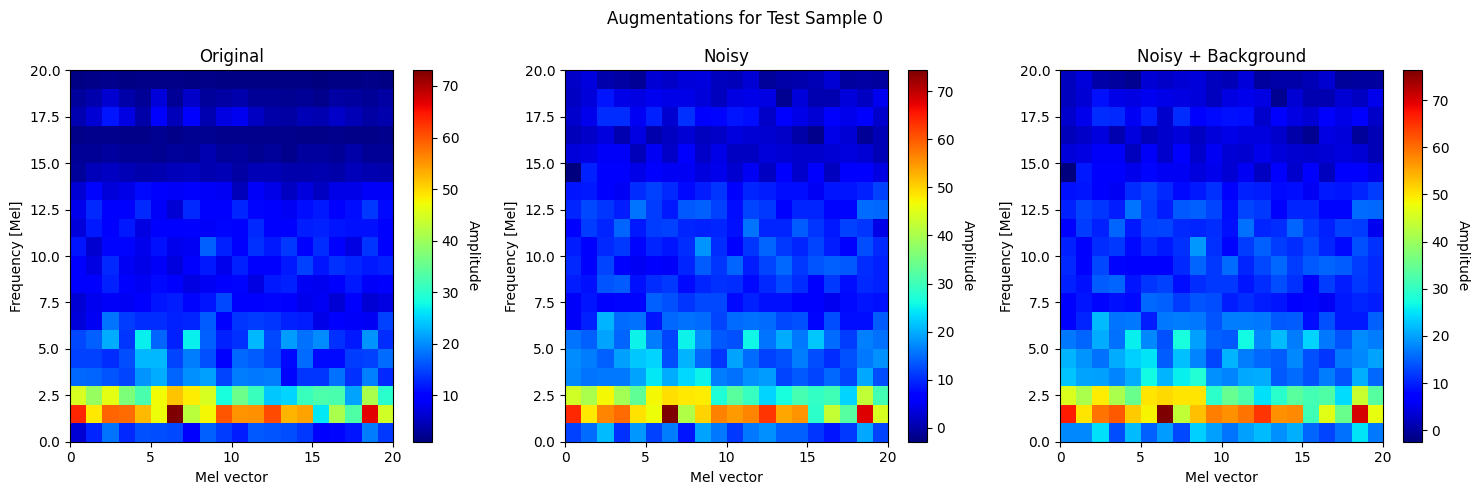

Affichage des augmentations du test set:  10%|█         | 1/10 [00:01<00:10,  1.16s/it]

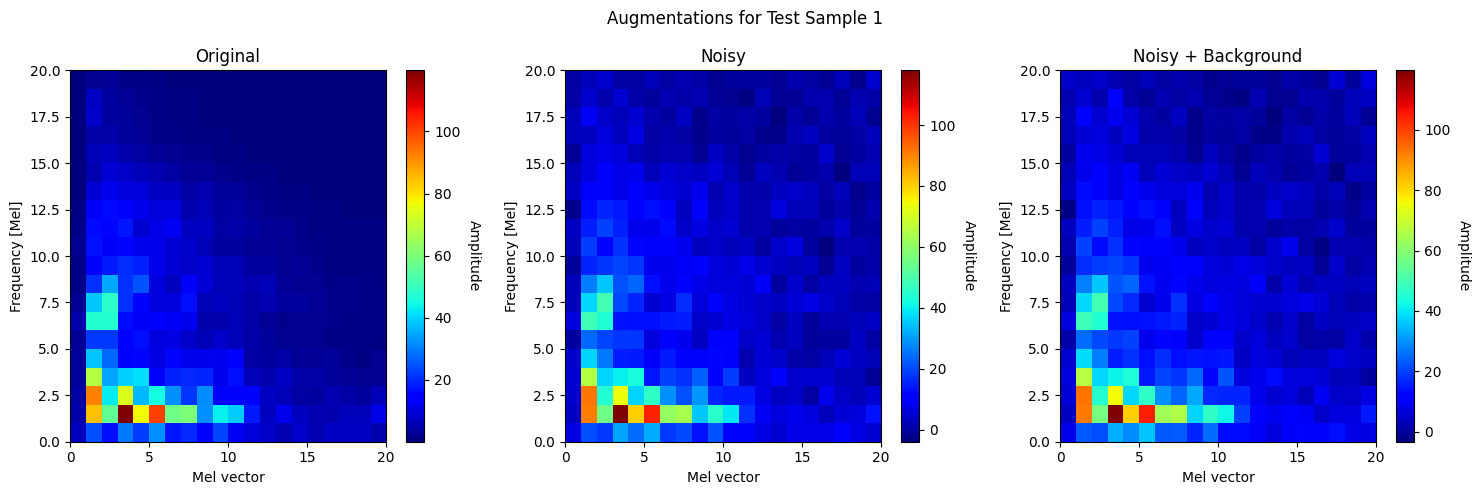

Affichage des augmentations du test set:  20%|██        | 2/10 [00:02<00:09,  1.13s/it]

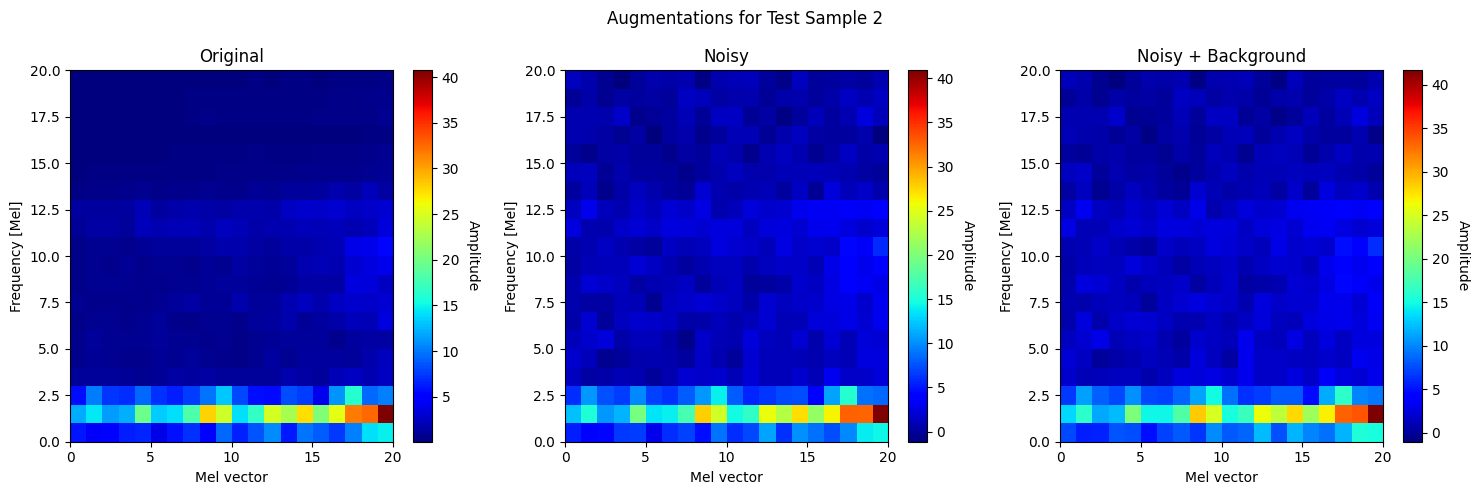

Affichage des augmentations du test set:  30%|███       | 3/10 [00:03<00:07,  1.13s/it]

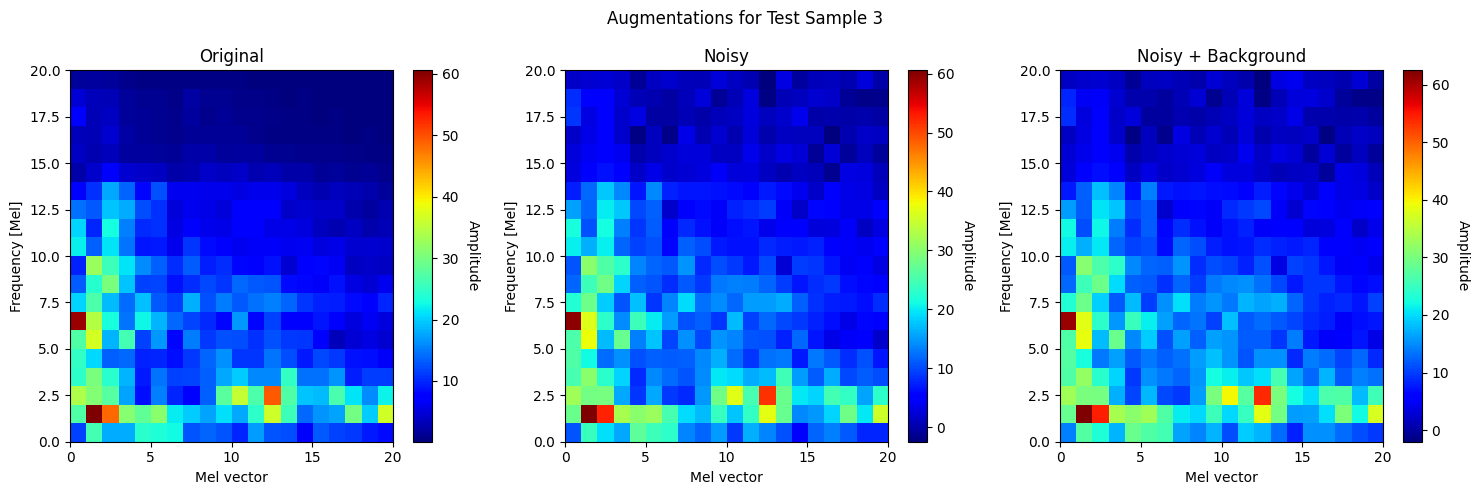

Affichage des augmentations du test set:  40%|████      | 4/10 [00:04<00:06,  1.12s/it]

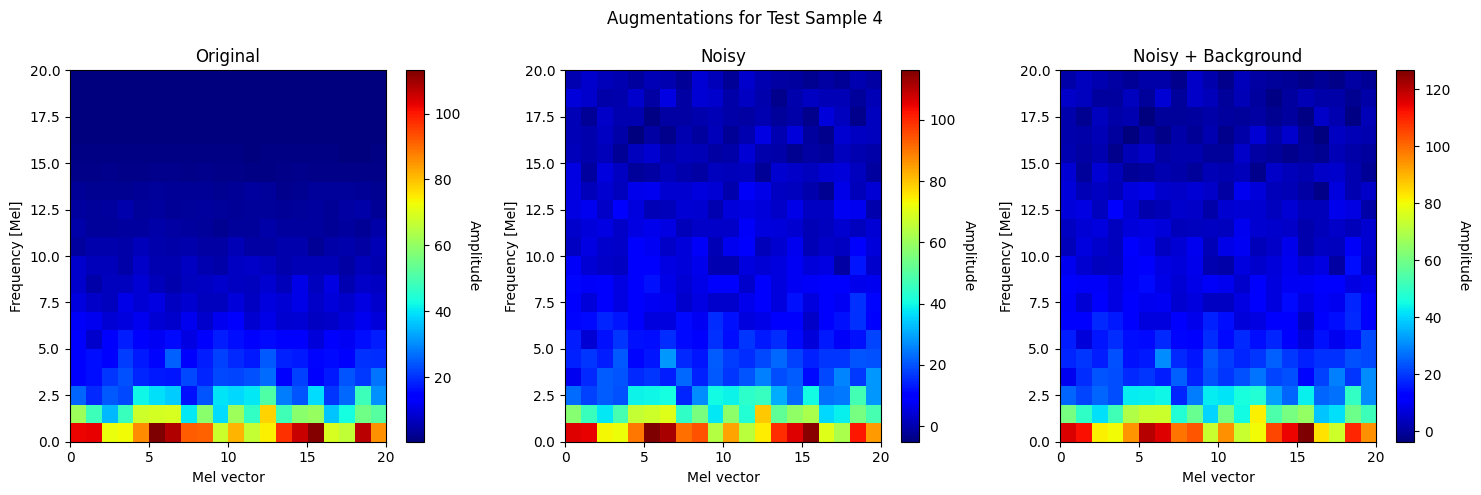

Affichage des augmentations du test set:  50%|█████     | 5/10 [00:05<00:05,  1.10s/it]

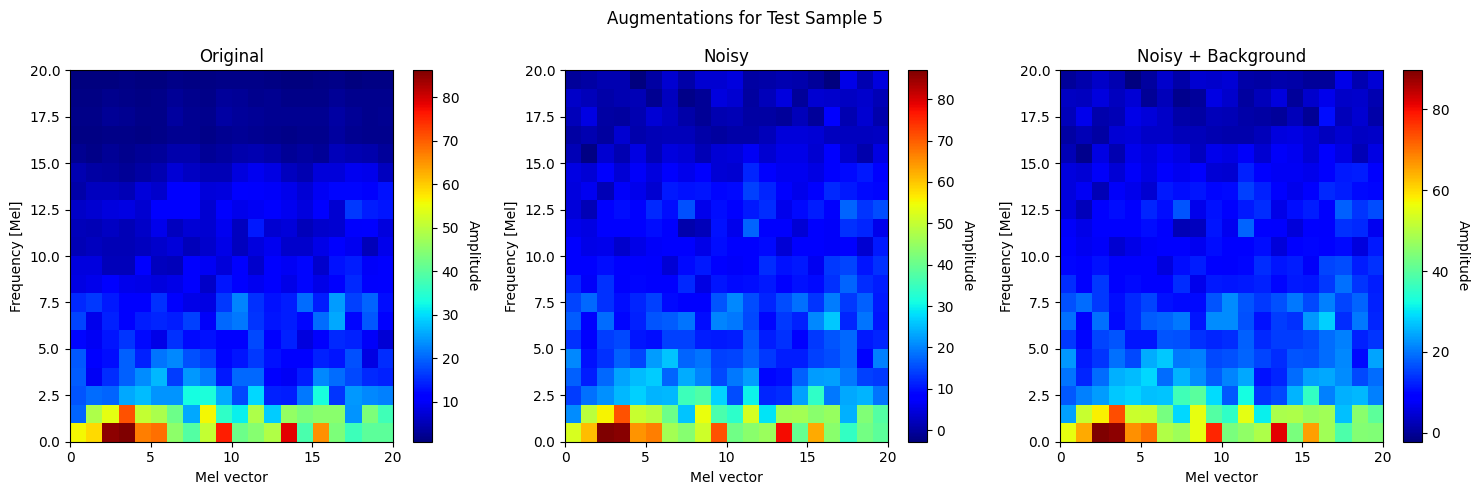

Affichage des augmentations du test set:  60%|██████    | 6/10 [00:06<00:04,  1.08s/it]

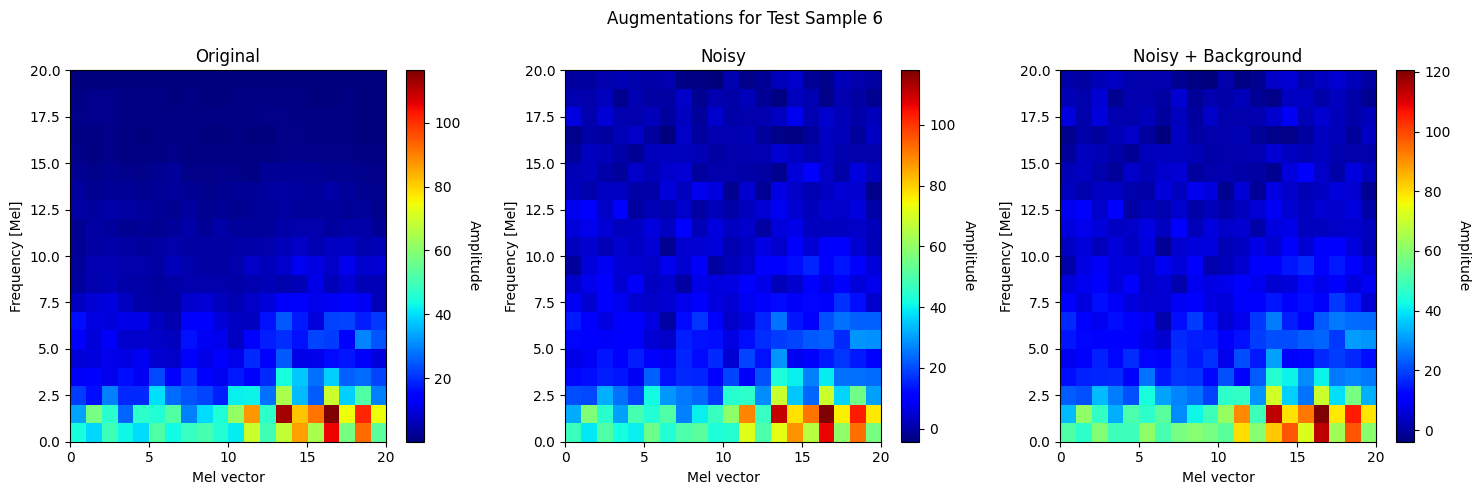

Affichage des augmentations du test set:  70%|███████   | 7/10 [00:08<00:03,  1.22s/it]

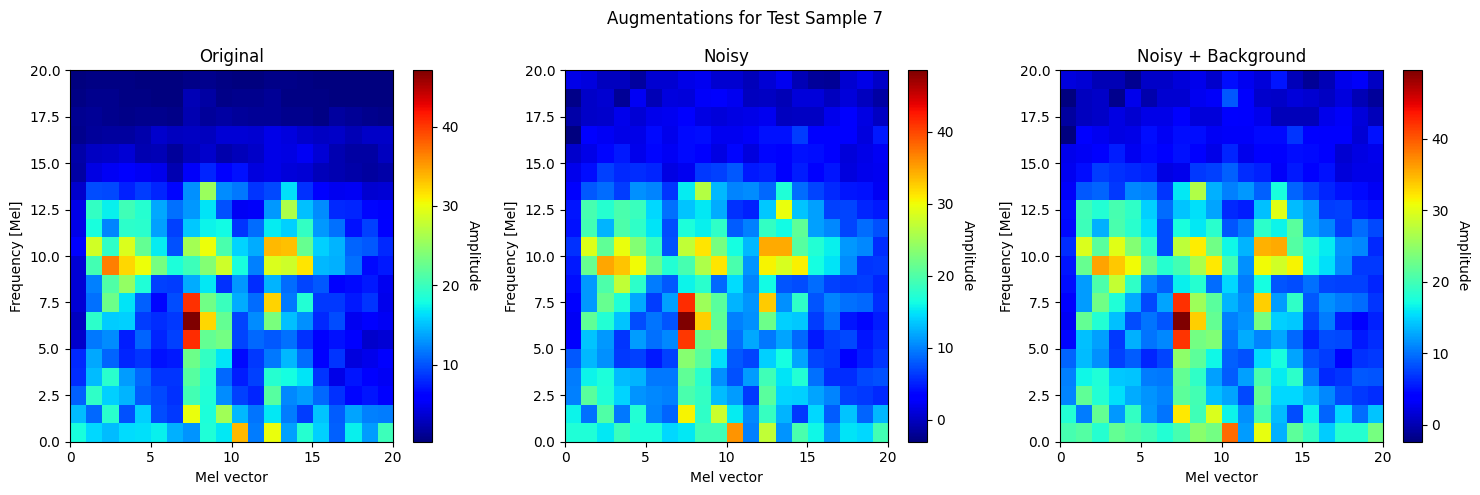

Affichage des augmentations du test set:  80%|████████  | 8/10 [00:09<00:02,  1.16s/it]

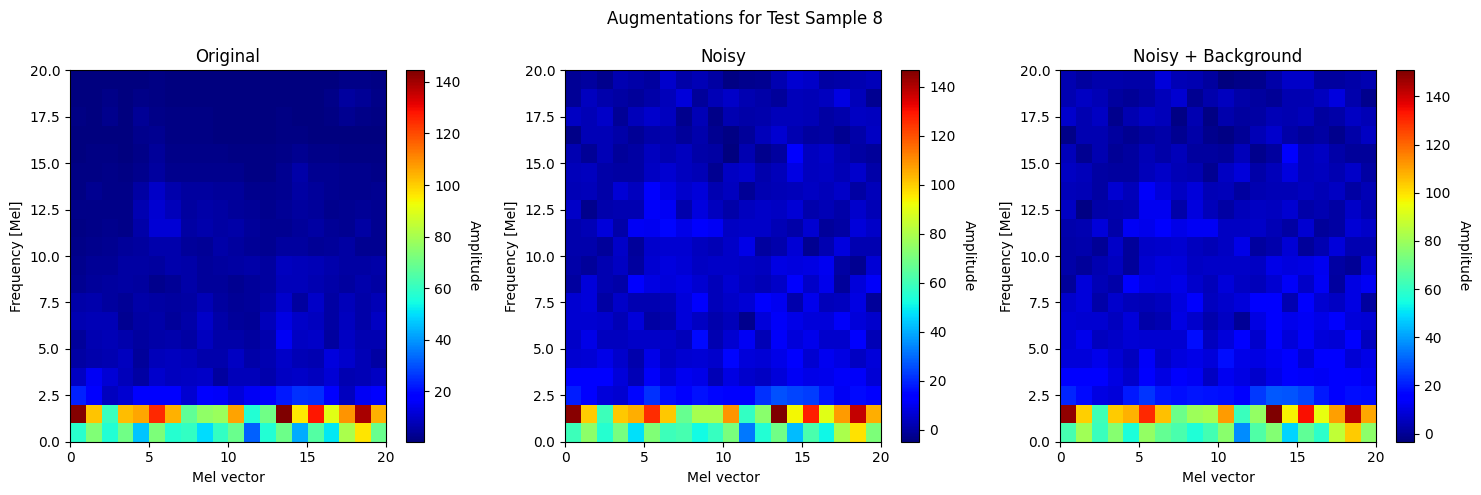

Affichage des augmentations du test set:  90%|█████████ | 9/10 [00:10<00:01,  1.15s/it]

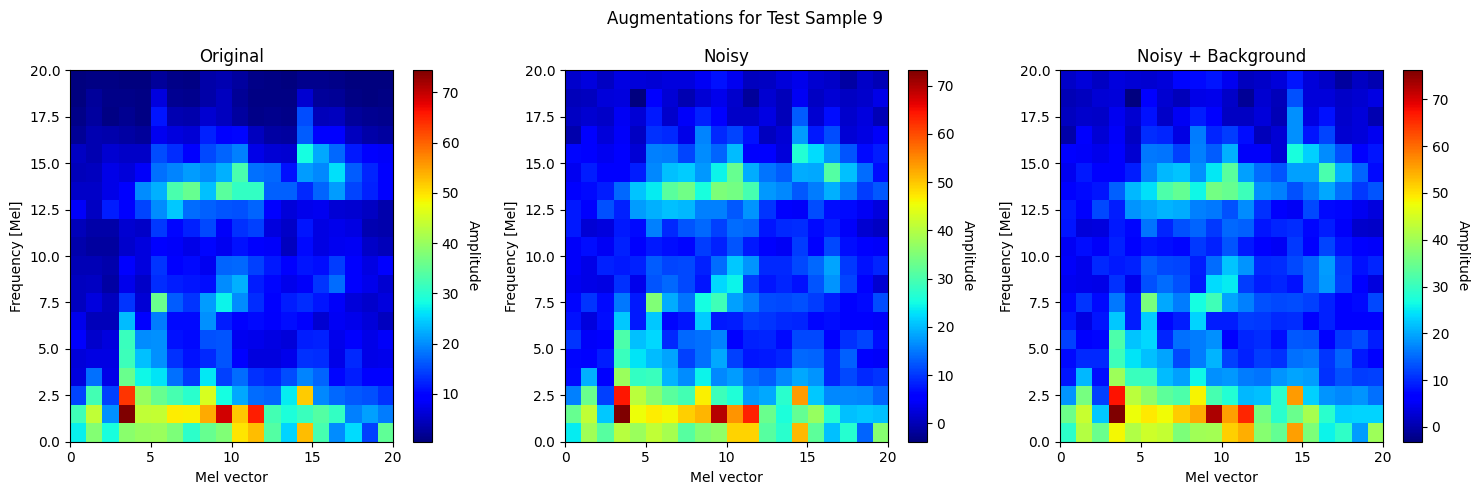

Affichage des augmentations du test set:  90%|█████████ | 9/10 [00:11<00:01,  1.27s/it]


In [123]:
index = 0
for i, vector in enumerate(tqdm(X_test[:10], desc="Affichage des augmentations du test set")):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Créez une figure avec 3 sous-graphiques

    # Afficher le vecteur original depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[0],
        is_mel=True,
        title="Original",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    # Afficher le vecteur avec bruit gaussien depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[1],
        is_mel=True,
        title="Noisy",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    # Afficher le vecteur avec bruit de fond depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[2],
        is_mel=True,
        title="Noisy + Background",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    plt.suptitle(f"Augmentations for Test Sample {i}")
    plt.tight_layout()
    plt.show()

    # Limiter à un certain nombre d'exemples pour éviter trop de graphiques
    if i >= 9:
        break

In [ ]:
# Résumé des augmentations effectuées :
# Train set :
# 1. Vecteur original
# 2. Décalage temporel (time shift) avec plusieurs pourcentages (shift_pcts)
# 3. Ajout de bruit gaussien (SNR = 20 dB)
# 4. Ajout de bruit de fond (SNR = 20 dB)

# Test set :
# 1. Vecteur original
# 2. Ajout de bruit gaussien (SNR = 20 dB)
# 3. Ajout de bruit de fond (SNR = 20 dB)


# à la toute fin pour le modèle final
# 4. Décalage temporel (time shift) avec plusieurs pourcentages (shift_pcts)
# sur le test set

In [ ]:
X_train_aug -= np.mean(X_train_aug, axis=0)
X_train_aug /= np.linalg.norm(X_train_aug, axis=0)

X_test_aug -= np.mean(X_test_aug, axis=0)
X_test_aug /= np.linalg.norm(X_test_aug, axis=0)

np.save(fm_dir + "feature_matrix_400_aug.npy", X_train_aug)
np.save(fm_dir + "labels_400_aug.npy", y_train_aug)
np.save(fm_dir + "feature_matrix_400_test_aug.npy", X_test_aug)
np.save(fm_dir + "labels_400_test_aug.npy", y_test)

# X_train_aug = np.load(fm_dir + "feature_matrix_400_aug.npy")
# y_train_aug = np.load(fm_dir + "labels_400_aug.npy", allow_pickle=True)
# X_test_aug = np.load(fm_dir + "feature_matrix_400_test_aug.npy")
# y_test = np.load(fm_dir + "labels_400_test_aug.npy", allow_pickle=True)
# print(f"Shape of the training feature matrix : {X_train_aug.shape}")
# print(f"Number of training labels : {y_train_aug.shape}")
# print(f"Shape of the test feature matrix : {X_test_aug.shape}")
# print(f"Number of test labels : {y_test.shape}")


Affichage des augmentations du test set:   0%|          | 0/10 [00:00<?, ?it/s]

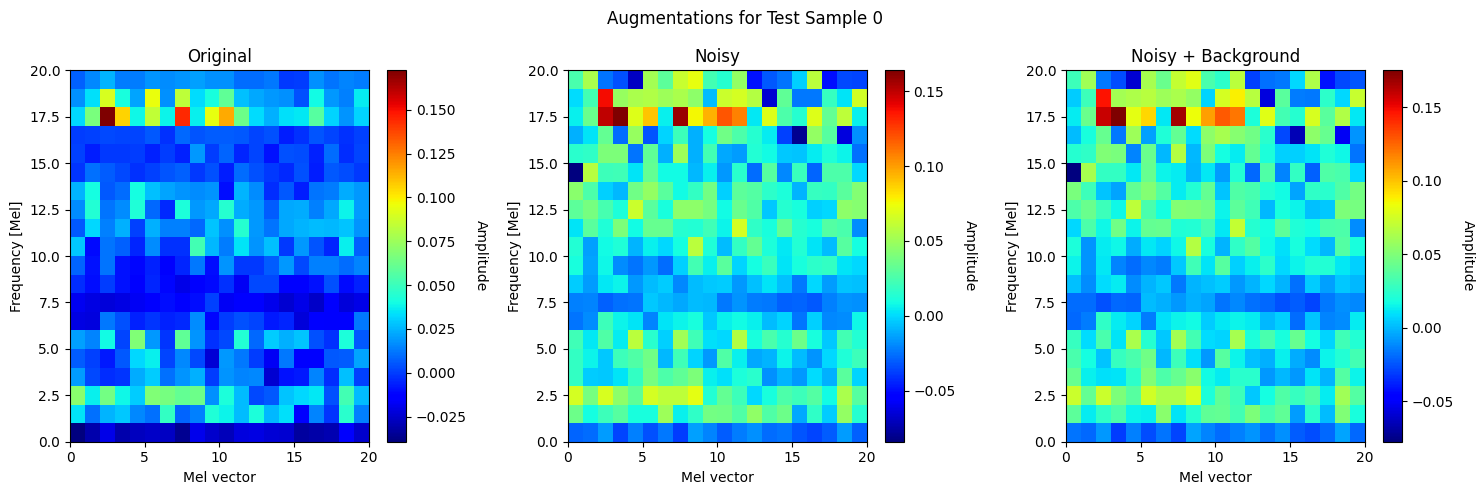

Affichage des augmentations du test set:  10%|█         | 1/10 [00:01<00:09,  1.08s/it]

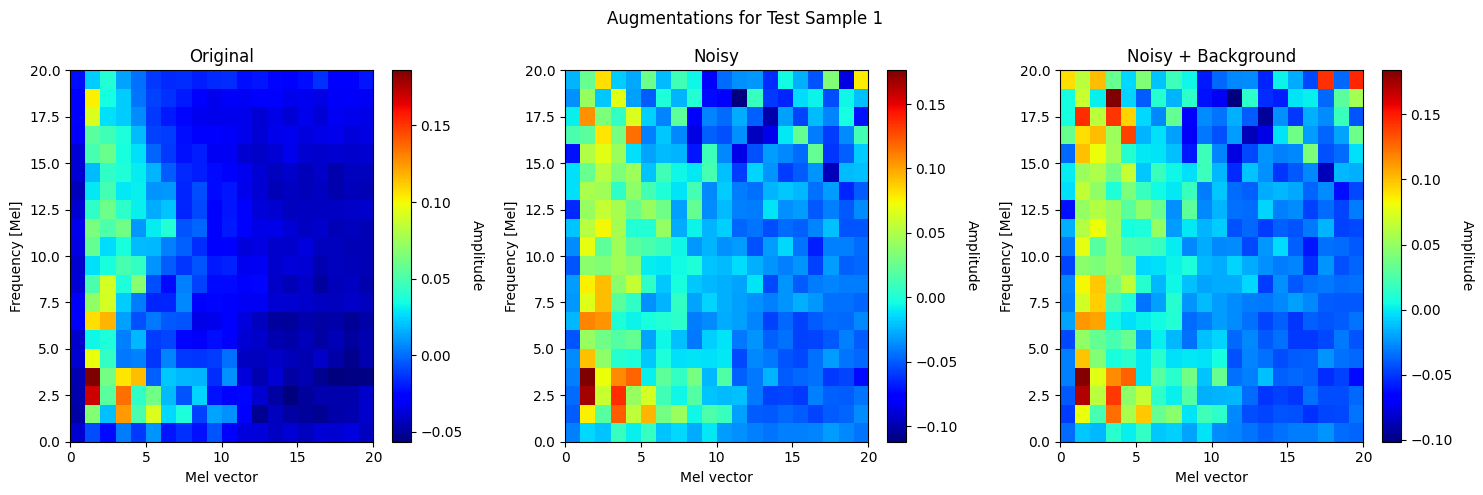

Affichage des augmentations du test set:  20%|██        | 2/10 [00:02<00:08,  1.06s/it]

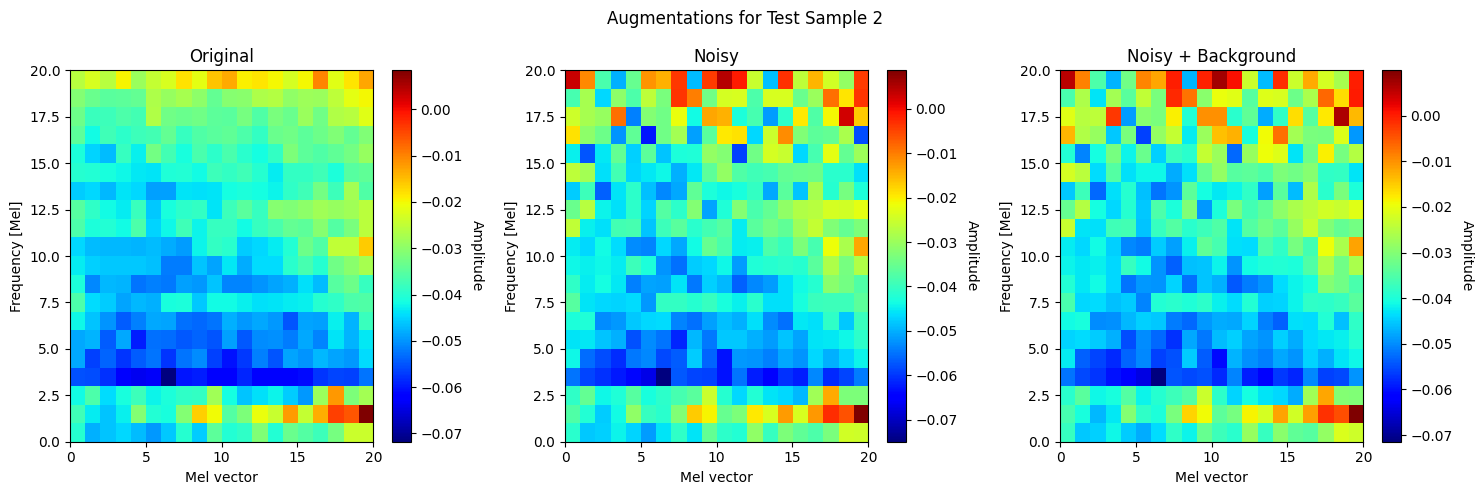

Affichage des augmentations du test set:  30%|███       | 3/10 [00:03<00:07,  1.06s/it]

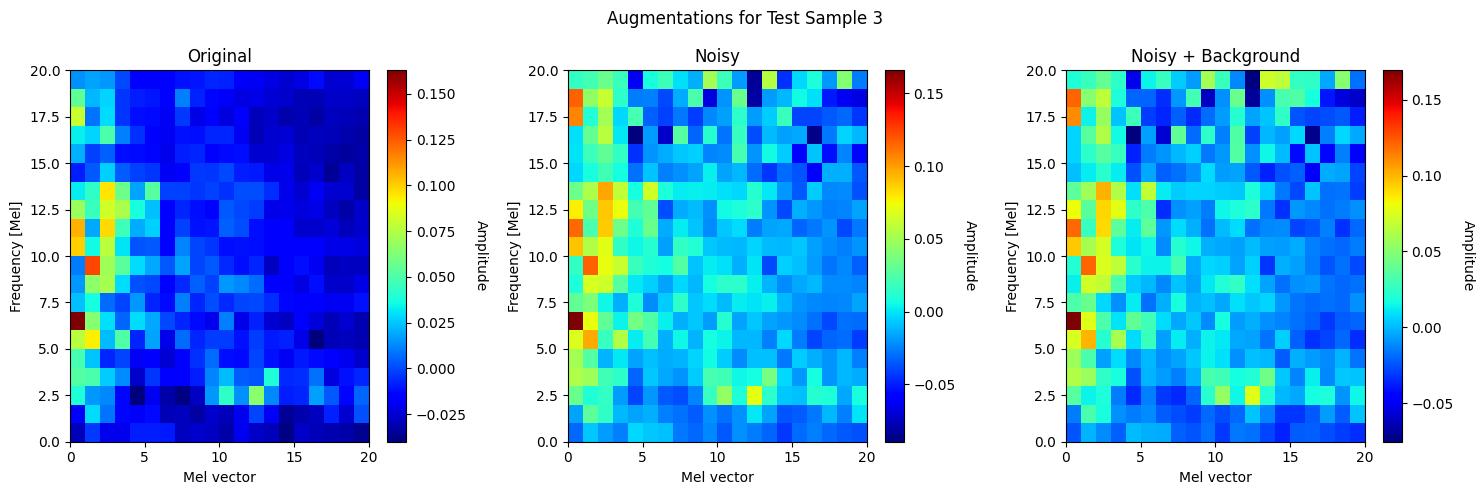

Affichage des augmentations du test set:  40%|████      | 4/10 [00:04<00:06,  1.05s/it]

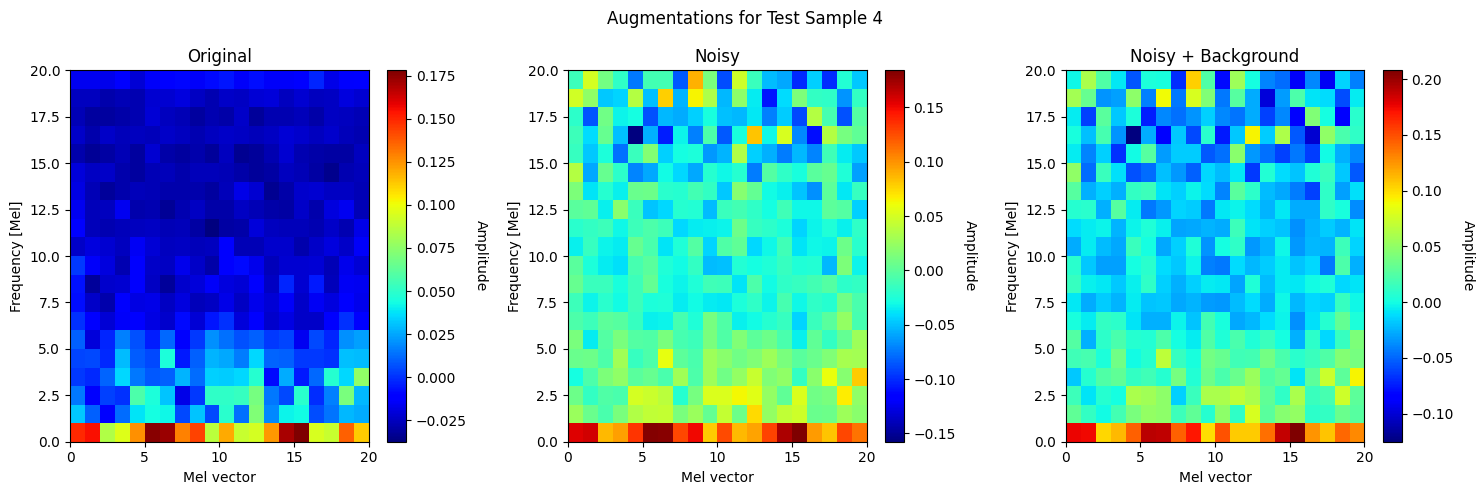

Affichage des augmentations du test set:  50%|█████     | 5/10 [00:05<00:05,  1.05s/it]

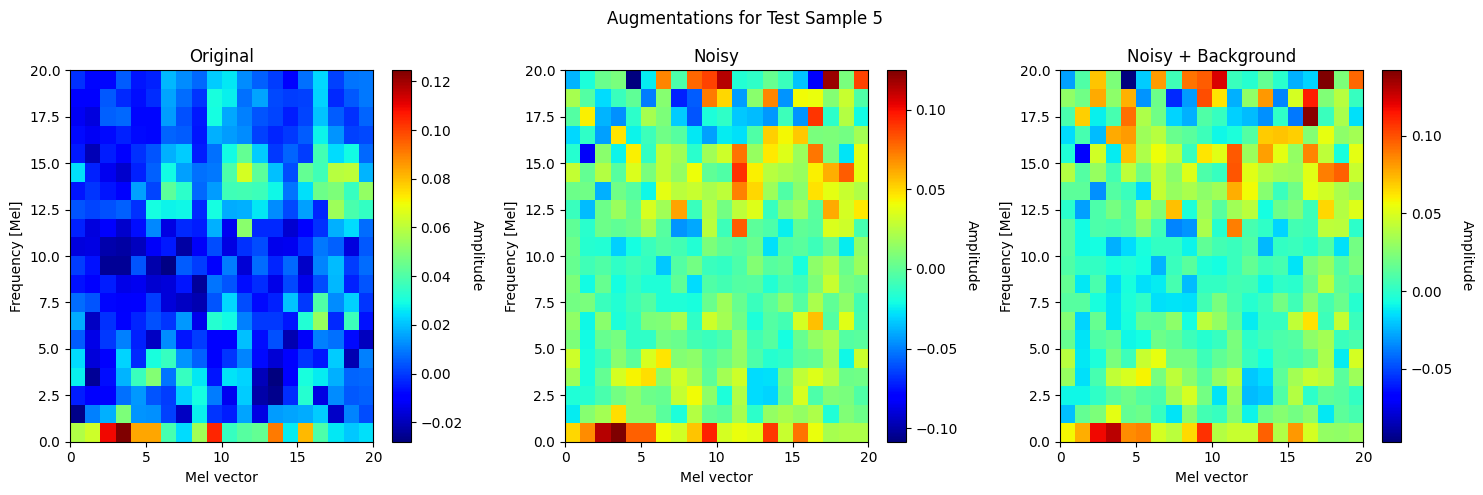

Affichage des augmentations du test set:  60%|██████    | 6/10 [00:06<00:04,  1.03s/it]

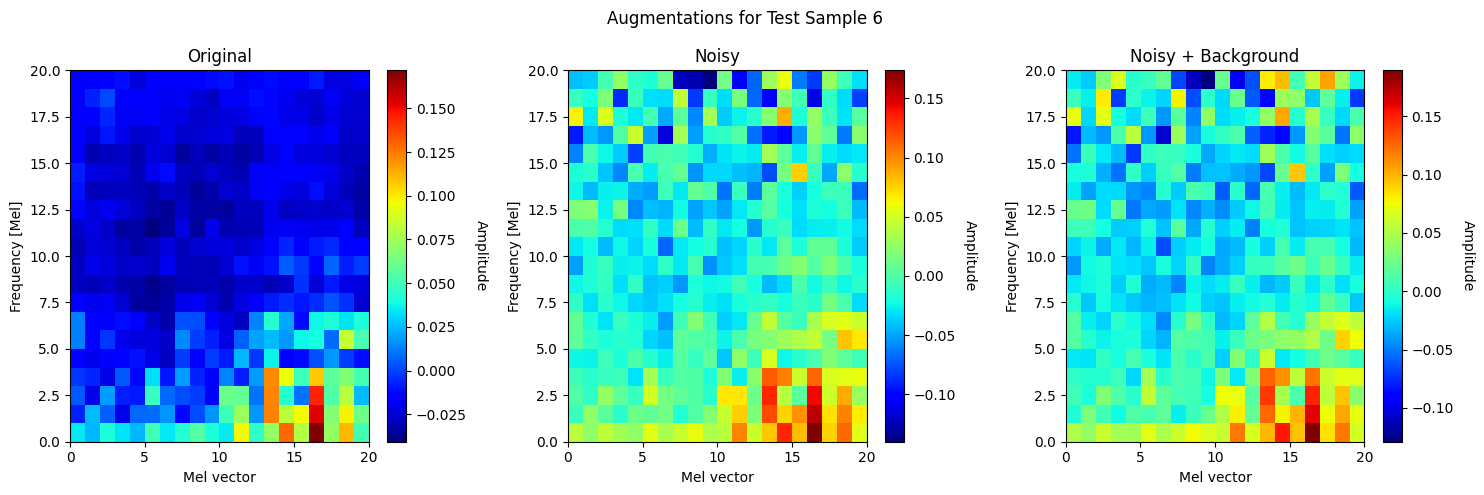

Affichage des augmentations du test set:  70%|███████   | 7/10 [00:07<00:03,  1.04s/it]

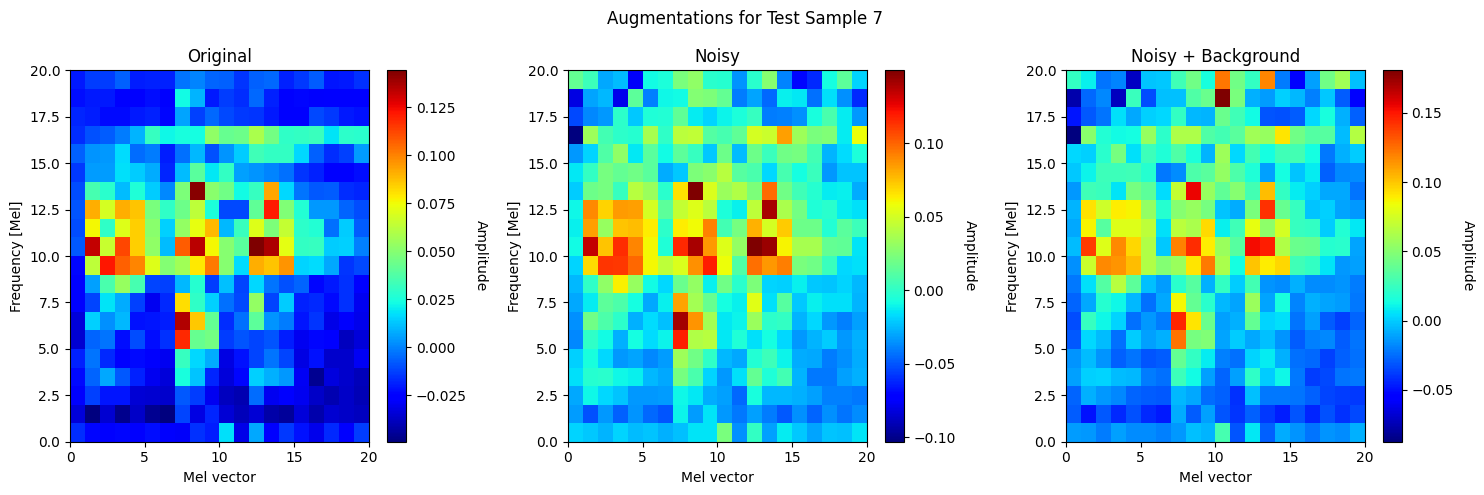

Affichage des augmentations du test set:  80%|████████  | 8/10 [00:08<00:02,  1.05s/it]

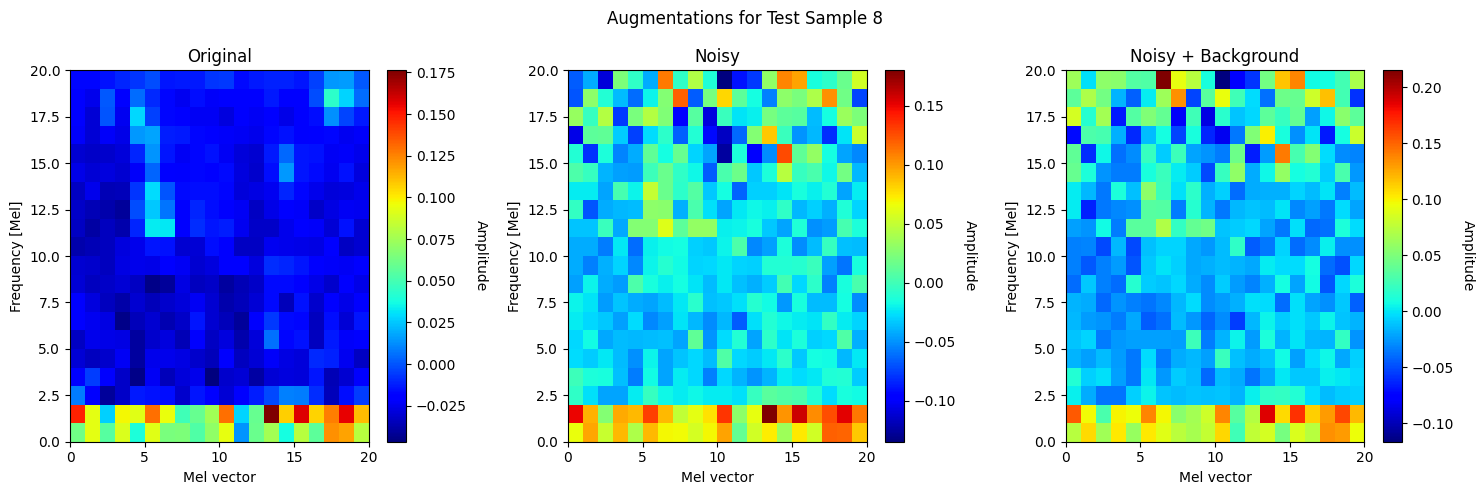

Affichage des augmentations du test set:  90%|█████████ | 9/10 [00:09<00:01,  1.18s/it]

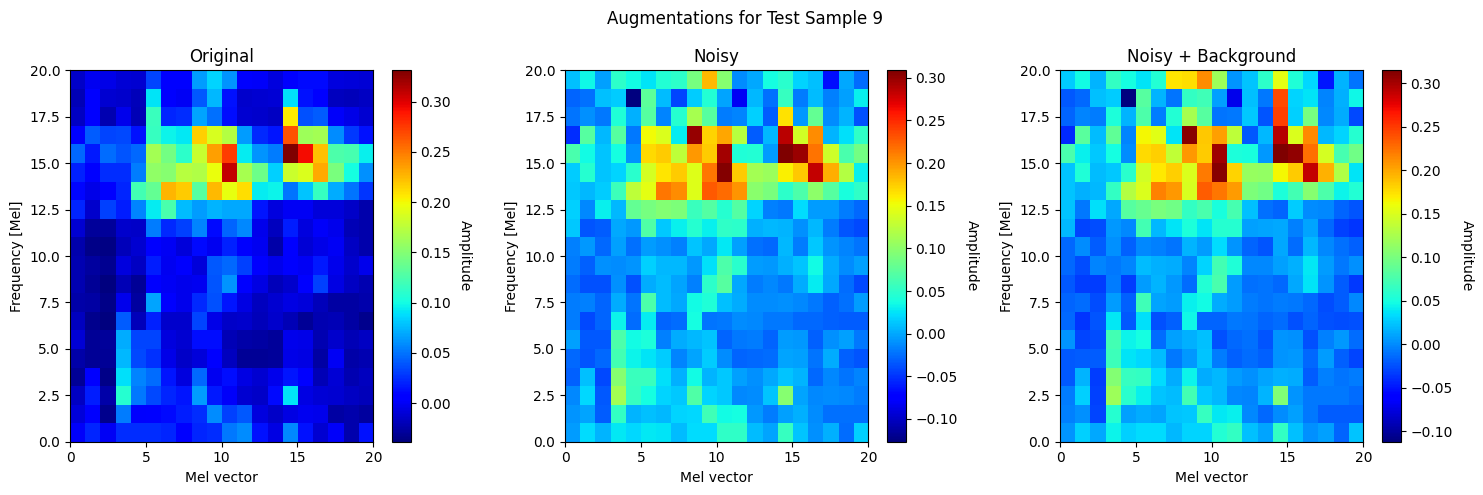

Affichage des augmentations du test set:  90%|█████████ | 9/10 [00:10<00:01,  1.21s/it]


In [125]:

index = 0
for i, vector in enumerate(tqdm(X_test[:10], desc="Affichage des augmentations du test set")):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Créez une figure avec 3 sous-graphiques

    # Afficher le vecteur original depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[0],
        is_mel=True,
        title="Original",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    # Afficher le vecteur avec bruit gaussien depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[1],
        is_mel=True,
        title="Noisy",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    # Afficher le vecteur avec bruit de fond depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[2],
        is_mel=True,
        title="Noisy + Background",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    plt.suptitle(f"Augmentations for Test Sample {i}")
    plt.tight_layout()
    plt.show()

    # Limiter à un certain nombre d'exemples pour éviter trop de graphiques
    if i >= 9:
        break

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score
import numpy as np

# Définir la fonction objectif pour Optuna
def objective(trial):
    # Définir les hyperparamètres à optimiser
    n_estimators = trial.suggest_int("n_estimators", 300, 500, step=100)
    max_depth = trial.suggest_categorical("max_depth", [None, 5, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.01, step=0.0025)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced"])

    # Créer le modèle avec les hyperparamètres suggérés
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=min_impurity_decrease,
        max_features=max_features,
        class_weight=class_weight,
        random_state=42,
    )

    # Évaluer le modèle avec une validation croisée
    scores = cross_val_score(
        rf, X_train_aug, y_train_aug, cv=3, scoring=make_scorer(balanced_accuracy_score)
    )
    return np.mean(scores)

# Créer une étude Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Afficher les meilleurs hyperparamètres et le score
print("Best parameters found: ", study.best_params)
print("Best score found: ", study.best_value)

# Entraîner le modèle final avec les meilleurs hyperparamètres
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train_aug, y_train_aug)

# Évaluer le modèle sur le test set
y_test_pred = best_rf.predict(X_test_aug)
test_score = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced accuracy on the test set: {test_score:.4f}")

/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-07 09:35:29,438] A new study created in memory with name: no-name-7e6ebc9b-9f52-4cd2-a266-207204e08302
[I 2025-05-07 09:35:37,438] Trial 0 finished with value: 0.7741062156950007 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.006, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7741062156950007.
[I 2025-05-07 09:35:49,247] Trial 1 finished with value: 0.766880532067448 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.009000000000000001, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with 

KeyboardInterrupt: 

In [ ]:

X_train_aug = np.load(fm_dir + "feature_matrix_400_aug.npy")
y_train_aug = np.load(fm_dir + "labels_400_aug.npy", allow_pickle=True)
X_test_aug = np.load(fm_dir + "feature_matrix_400_test_aug.npy")
y_test = np.load(fm_dir + "labels_400_test_aug.npy", allow_pickle=True)

Number of labels: (473,)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mean accuracy with Random Forest 5-Fold CV: 77.4%
Std deviation in accuracy with 5-Fold CV: 5.6%
Test set accuracy with Random Forest: 83.54%


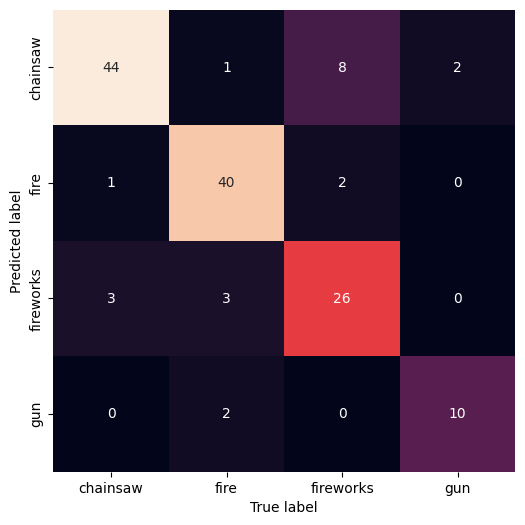

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm  


# Entraîner le modèle Random Forest sans PCA
best_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    min_impurity_decrease=0.0,
    random_state=42,
    max_features="sqrt",
)
best_rf.fit(X_train_aug, y_train_aug)

# Évaluer le modèle sur le test set sans PCA
y_test_pred_no_pca = best_rf.predict(X_test_aug)
test_accuracy_no_pca = balanced_accuracy_score(y_test, y_test_pred_no_pca)

# Stocker la précision sans PCA
accuracies_with_pca = []
pca_components = list(range(1, 51,2))

# Appliquer PCA et évaluer le modèle avec PCA
for n_components in tqdm(pca_components, desc="Evaluating PCA components"):
    pca = PCA(n_components=n_components, whiten=True)
    X_train_pca = pca.fit_transform(X_train_aug)
    X_test_pca = pca.transform(X_test_aug)

    # Entraîner le modèle Random Forest avec PCA
    best_rf.fit(X_train_pca, y_train_aug)

    # Évaluer le modèle sur le test set avec PCA
    y_test_pred_with_pca = best_rf.predict(X_test_pca)
    test_accuracy_with_pca = balanced_accuracy_score(y_test, y_test_pred_with_pca)
    accuracies_with_pca.append(test_accuracy_with_pca)

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(pca_components, [test_accuracy_no_pca] * len(pca_components), label="Without PCA", linestyle="--")
plt.plot(pca_components, accuracies_with_pca, label="With PCA", marker="o")
plt.title("Balanced Accuracy with and without PCA (Augmented Training Set)")
plt.xlabel("Number of PCA Components")
plt.ylabel("Balanced Accuracy [%]")
plt.legend()
plt.grid(True)

# Sauvegarder le graphique en PDF
pdf_filename = "balanced_accuracy_with_without_pca_augmented.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()  # Sauvegarder la figure actuelle
    plt.close()

print(f"Plot saved as {pdf_filename}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


# Charger les données augmentées
X_train_aug = np.load(fm_dir + "feature_matrix_400_aug.npy")
y_train_aug = np.load(fm_dir + "labels_400_aug.npy", allow_pickle=True)
X_test_aug = np.load(fm_dir + "feature_matrix_400_test_aug.npy")
y_test_aug = np.load(fm_dir + "labels_400_test_aug.npy", allow_pickle=True)

# Charger les données originales
X = np.load(fm_dir + "feature_matrix_400.npy")
y = np.load(fm_dir + "labels_400.npy", allow_pickle=True)

# Initialiser les listes pour stocker les scores de précision équilibrée
original_scores = []
augmented_scores = []

# Effectuer l'évaluation 10 fois
for _ in range(10):
    # Diviser les données originales en training et test sets
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=0.3, random_state=None, stratify=y
    )

    # Définir le modèle Random Forest
    rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=9,
    min_samples_leaf=6,
    min_impurity_decrease=0.0,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)


    # Entraîner et évaluer sur le dataset original
    rf_model.fit(X_train_orig, y_train_orig)
    y_pred_orig = rf_model.predict(X_test_orig)
    accuracy_orig = balanced_accuracy_score(y_test_orig, y_pred_orig)
    original_scores.append(accuracy_orig)

    # Entraîner et évaluer sur le dataset augmenté
    rf_model.fit(X_train_aug, y_train_aug)
    y_pred_aug = rf_model.predict(X_test_aug)
    accuracy_aug = balanced_accuracy_score(y_test_aug, y_pred_aug)
    augmented_scores.append(accuracy_aug)

# Créer un box plot pour comparer les résultats
plt.figure(figsize=(10, 6))
plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])
plt.title("Comparison of Balanced Accuracy Scores for Random Forest Model")
plt.ylabel("Balanced Accuracy Score")
plt.grid(True)

# Sauvegarder le graphique en PDF
pdf_filename = "rf_balanced_accuracy_comparison.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()  # Sauvegarder la figure actuelle
    plt.close()

# Afficher les résultats
print(f"Original Dataset: Mean = {np.mean(original_scores):.4f}, Std = {np.std(original_scores):.4f}")
print(f"Augmented Dataset: Mean = {np.mean(augmented_scores):.4f}, Std = {np.std(augmented_scores):.4f}")
print(f"Box plot saved as {pdf_filename}")

Original Dataset: Mean = 0.7689, Std = 0.0491
Augmented Dataset: Mean = 0.8504, Std = 0.0089
Box plot saved as rf_balanced_accuracy_comparison.pdf


/tmp/ipykernel_105092/2743479153.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])


In [26]:
from sklearn.model_selection import cross_val_score

# Charger les données augmentées
X_train_aug = np.load(fm_dir + "feature_matrix_400_aug.npy")
y_train_aug = np.load(fm_dir + "labels_400_aug.npy", allow_pickle=True)
X_test_aug = np.load(fm_dir + "feature_matrix_400_test_aug.npy")
y_test_aug = np.load(fm_dir + "labels_400_test_aug.npy", allow_pickle=True)

# Définir le modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=9,
    min_samples_leaf=6,
    min_impurity_decrease=0.0,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)


print("Performing cross-validation...")
cv_scores = cross_val_score(
    rf_model, X_train_aug, y_train_aug, cv=5, scoring=make_scorer(balanced_accuracy_score)
)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores):.4f}, Std: {np.std(cv_scores):.4f}")

print("Training the final model on the full augmented training set...")
rf_model.fit(X_train_aug, y_train_aug)

print("Evaluating the final model on the test set...")
y_test_pred = rf_model.predict(X_test_aug)
test_score = balanced_accuracy_score(y_test_aug, y_test_pred)
print(f"Balanced accuracy on the test set: {test_score:.4f}")


Performing cross-validation...
Cross-validation scores: [0.73105869 0.83747159 0.83323615 0.85505341 0.81266571]
Mean CV score: 0.8139, Std: 0.0436
Training the final model on the full augmented training set...
Evaluating the final model on the test set...
Balanced accuracy on the test set: 0.5448


In [ ]:
import pickle
import numpy as np
from tqdm import tqdm

# Charger les données originales
X_test = np.load(fm_dir + "feature_matrix_400_test.npy")
y_test = np.load(fm_dir + "labels_400_test.npy", allow_pickle=True)

# Charger les données augmentées d'entraînement
X_train_aug = np.load(fm_dir + "feature_matrix_400_aug.npy")
y_train_aug = np.load(fm_dir + "labels_400_aug.npy", allow_pickle=True)

# Définir les pourcentages de décalage
shift_pcts = [0.2, 0.5, 0.8]

# Calculer la taille totale des augmentations pour le test set
n_augmentations_test = len(X_test) * len(shift_pcts)  # Seulement time shift
total_test_aug = len(X_test) + n_augmentations_test  # Original + décalages

# Préallouer les tableaux pour le test set
X_test_aug = np.zeros((total_test_aug, X_test.shape[1]))
y_test_aug = np.zeros(total_test_aug, dtype=y_test.dtype)

# Remplir les tableaux préalloués pour le test set
index = 0
for vector, label in tqdm(zip(X_test, y_test), total=len(X_test), desc="Augmenting test set"):
    # Ajouter le vecteur original
    X_test_aug[index] = vector
    y_test_aug[index] = label
    index += 1

    # Appliquer les augmentations de décalage temporel
    for shift_pct in shift_pcts:
        shifted_vector = time_shift_vector(vector, shift_pct=shift_pct)
        X_test_aug[index] = shifted_vector
        y_test_aug[index] = label
        index += 1

# Sauvegarder les données augmentées du test set
np.save(fm_dir + "feature_matrix_400_test_aug_extended.npy", X_test_aug)
np.save(fm_dir + "labels_400_test_aug_extended.npy", y_test_aug)

# Combiner les données d'entraînement et de test augmentées
X_full = np.vstack((X_train_aug, X_test_aug))
y_full = np.hstack((y_train_aug, y_test_aug))

# Définir le modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=9,
    min_samples_leaf=6,
    min_impurity_decrease=0.0,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)


# Entraîner le modèle final sur toutes les données disponibles
print("Training the final model on the full dataset (train + test augmented)...")
rf_model.fit(X_full, y_full)

# Sauvegarder le modèle au format pickle
model_filename = model_dir + "random_forest_model_final.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(rf_model, model_file)
print(f"Final model saved to {model_filename}")